# Model Diversity

## Imports and Functions

In [1]:
import pickle
import re

import pandas as pd
import numpy as np
import plotly.express as px
import matplotlib.pyplot as plt

# preprocessing
from sklearn.preprocessing import OneHotEncoder#, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

# prep for models and search parameter space
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline

# selection of features
from sklearn.decomposition import PCA

# models
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import ComplementNB, MultinomialNB
from sklearn.ensemble import RandomForestClassifier

# model evaluation
from sklearn.metrics import (
    ConfusionMatrixDisplay, PrecisionRecallDisplay, RocCurveDisplay, 
    classification_report, 
    accuracy_score, f1_score, precision_score, recall_score, 
    roc_curve, roc_auc_score, precision_recall_curve, 
)

### Functions

In [2]:
def evaluate_model(model, X_test, y_test, save_figs = False, fig_subtitle = 'Model details here', 
                   short_name='short', return_misclassified=False, return_all_results=False):
    '''
    For models that predict probability of classification: evaluates model, creates useful figures, and returns metric scores and data frame of misclassified results

    Parameters
    ----------
    model : object that contains the model

    X_test : array-like of shape (n_samples, n_features)
        the features in the test data
    y_test : array-like of shape (n_samples,)
        the true classification of the test data
    save_figs : bool, default = False
        tells function to save figures created or not
    fig_subtitle : str, default = "Model details here"
        string to form the subtitle of figures
    short_name : str, default = "short"
        string used name saved figures and scoring dictionary
    return_misclassified : bool, default = False
        returns Data Frame of misclassified results when True: true value, predicted value, probability calculated by model
    return_all_results : bool, default = False
        returns Data Frame of all results when True: true value, predicted value, probability calculated by model

    Returns
    -------
    scores : dict
        dictionary containing model short_name and calculated accuracy, precision, recall, f1-score, and roc-auc-score
    res : pandas Data Frame, optional
        contains the true values, predicted values, and calculated probabilities for misclassified results, only returned if `return_misclassified == True`
    res_all : panda Data Frame, optional
        contains the true values, predicted values, and calculated probabilities for all results, only returned if `return_all_results == True`
    '''
    preds = model.predict(X_test)
    proba = model.predict_proba(X_test)

    # confusion matrix
    fig_cm, ax_cm = plt.subplots()
    
    ConfusionMatrixDisplay.from_predictions(y_test, preds, display_labels=['real','fraudulent'], ax=ax_cm)
    ax_cm.set_title(f'Confusion Matrix: {fig_subtitle}');
    
    fig_cm.show()
    
    # classification report
    print(f"\nClassification Report: \n")
    print(classification_report(y_test, preds, target_names=['real', 'fraudulent']))

    # metrics: accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
    scores = {
        'model': short_name,
        'accuracy': accuracy_score(y_test, preds),
        'precision': precision_score(y_test, preds),
        'recall': recall_score(y_test, preds),
        'f1_score': f1_score(y_test, preds),
        'roc_auc_score': roc_auc_score(y_test, preds),
    }
    
    # misclassified results
    results = []
    for i in range(len(y_test)):
        if preds[i] != y_test.iloc[i]:
            results.append({'actual': y_test.iloc[i], 'predicted': preds[i], 'prob_fraud': proba[i][1]})

    res = pd.DataFrame(results)

    # probability histogram of misclassified results
    fig_hist = px.histogram(
        res, 
        x='prob_fraud', 
        title = 'Probability Distribution of Misclassified Job Ads', 
        subtitle= f'Model: {fig_subtitle}'
    )

    fig_hist.show()


    # all results
    if return_all_results == True:
        results_all = []
        for i in range(len(y_test)):
            results_all.append({'actual': y_test.iloc[i], 'predicted': preds[i], 'prob_fraud': proba[i][1]})
        
        res_all = pd.DataFrame(results_all)

    # precision-recall and roc curves
    fig_curves, axes = plt.subplots(1, 2, figsize=(12,6))

    fig_curves.suptitle(f'Model: {fig_subtitle}', fontsize=18)

    ax=axes[0]
    PrecisionRecallDisplay.from_predictions(y_test, preds, ax=ax)
    ax.set_title('Precision-Recall Curve')
    ax.set_ylabel('Precision')
    ax.set_xlabel('Recall')

    ax=axes[1]
    RocCurveDisplay.from_predictions(y_test, preds, ax=ax)
    ax.set_title('ROC curve')
    ax.set_ylabel('True Positive Rate')
    ax.set_xlabel('False Positive Rate');

    # save figures, if save_figs is True
    if save_figs == True:
        fig_cm.savefig(f'../images/cm_{short_name}.png')
        fig_hist.write_image(f'../images/hist_{short_name}.png')
        fig_curves.savefig(f'../images/curves_{short_name}.png')

    # return options
    if return_all_results == True and return_misclassified == True:
        return scores, res, res_all
    elif return_all_results == True:
        return scores, res_all
    elif return_misclassified == True:
        return scores, res
    else:
        return scores

In [3]:
def evaluate_model_noprob(model, X_test, y_test, save_figs = False, fig_subtitle = 'Model details here', 
                          short_name='short', return_all_results=False):
    '''
    For models that predict probability of classification: evaluates model, creates useful figures, and returns metric scores and data frame of misclassified results

    Parameters
    ----------
    model : object that contains the model

    X_test : array-like of shape (n_samples, n_features)
        the features in the test data
    y_test : array-like of shape (n_samples,)
        the true classification of the test data
    save_figs : bool, default = False
        tells function to save figures created or not
    fig_subtitle : str, default = 'Model details here'
        string to form the subtitle of figures
    short_name : str, default = 'short'
        string used name saved figures
    return_all_results : bool, default = False
        returns Data Frame of all results when True: true value, predicted value, probability calculated by model

    Returns
    -------
    scores : dict
        dictionary containing model short_name and calculated accuracy, precision, recall, f1-score, and roc-auc-score
    res_all : panda Data Frame, optional
        contains the true and predicted values for all results, only returned if `return_all_results == True`
    '''
    preds = model.predict(X_test)
    
    # confusion matrix
    fig_cm, ax_cm = plt.subplots()
    
    ConfusionMatrixDisplay.from_predictions(y_test, preds, display_labels=['real','fraudulent'], ax=ax_cm)
    ax_cm.set_title(f'Confusion Matrix: {fig_subtitle}');
    
    fig_cm.show()
    
    # classification report
    print(f"\nClassification Report: \n")
    print(classification_report(y_test, preds, target_names=['real', 'fraudulent']))

    # metrics: accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
    scores = {
        'model': short_name,
        'accuracy': accuracy_score(y_test, preds),
        'precision': precision_score(y_test, preds),
        'recall': recall_score(y_test, preds),
        'f1_score': f1_score(y_test, preds),
        'roc_auc_score': roc_auc_score(y_test, preds),
    }

    # all results
    if return_all_results == True:
        results_all = []
        for i in range(len(y_test)):
            results_all.append({'actual': y_test.iloc[i], 'predicted': preds[i]})
        
        res_all = pd.DataFrame(results_all)

    # precision-recall and roc curves
    fig_curves, axes = plt.subplots(1, 2, figsize=(12,6))

    fig_curves.suptitle(f'Model: {fig_subtitle}', fontsize=18)

    ax=axes[0]
    PrecisionRecallDisplay.from_predictions(y_test, preds, ax=ax)
    ax.set_title('Precision-Recall Curve')
    ax.set_ylabel('Precision')
    ax.set_xlabel('Recall')

    ax=axes[1]
    RocCurveDisplay.from_predictions(y_test, preds, ax=ax)
    ax.set_title('ROC curve')
    ax.set_ylabel('True Positive Rate')
    ax.set_xlabel('False Positive Rate');
    
    if save_figs == True:
        fig_cm.savefig(f'../images/cm_{short_name}.png')
        fig_curves.savefig(f'../images/curves_{short_name}.png')

    if return_all_results == True:
        return scores, res_all
    else:
        return scores

In [4]:
def save_model (model, filename):
    '''
    pickles model as filename.pkl in the models directory
    '''
    with open(f'./models/{filename}.pkl', 'wb') as f:
        pickle.dump(model, f)

### Functions to Style Tables

In [55]:
def highlight_max(s, props=''):
    return np.where(s == np.max(s.values), props, '')

In [56]:
def highlight_min(s, props=''):
    return np.where(s == np.min(s.values), props, '')

## Data Inport

In [5]:
df = pd.read_csv('../data/clean/job_ads.csv')

In [6]:
df.head()

,title,department,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent,job_ad,country
0,Marketing Intern,Marketing,0,1,0,Other,Internship,unknown,NaN,Marketing,0,"We're Food52, and we've created a groundbreaki...",US
1,Customer Service - Cloud Video Production,Success,0,1,0,Full-time,Not Applicable,unknown,Marketing and Advertising,Customer Service,0,"90 Seconds, the worlds Cloud Video Production ...",NZ
2,Commissioning Machinery Assistant (CMA),unknown,0,1,0,unknown,unknown,unknown,NaN,NaN,0,Valor Services provides Workforce Solutions th...,US
3,Account Executive - Washington DC,Sales,0,1,0,Full-time,Mid-Senior level,Bachelor's Degree,Computer Software,Sales,0,Our passion for improving quality of life thro...,US
4,Bill Review Manager,unknown,0,1,1,Full-time,Mid-Senior level,Bachelor's Degree,Hospital & Health Care,Health Care Provider,0,SpotSource Solutions LLC is a Global Human Cap...,US


## Data Exploration

In [7]:
df.columns

Index(['title', 'department', 'telecommuting', 'has_company_logo',
       'has_questions', 'employment_type', 'required_experience',
       'required_education', 'industry', 'function', 'fraudulent', 'job_ad',
       'country'],
      dtype='object')

### Target

In [8]:
df['fraudulent'].value_counts(normalize=True)

fraudulent
0    0.951566
1    0.048434
Name: proportion, dtype: float64

### `title`

In [9]:
df['title'].nunique()

11231

That's way too many to be helpful, going to __drop__ this column

### `department`

In [10]:
df['department'].nunique()

1338

Still too many to keep, __drop__ column.

### `employment_type`

In [11]:
df['employment_type'].nunique()

6

In [12]:
df['employment_type'].value_counts(normalize=True)

employment_type
Full-time    0.649888
unknown      0.194128
Contract     0.085235
Part-time    0.044575
Temporary    0.013479
Other        0.012696
Name: proportion, dtype: float64

Going to __one hot encode__ this column.

### `required_experience`

In [13]:
df['required_experience'].nunique()

8

In [14]:
df['required_experience'].value_counts(normalize=True)

required_experience
unknown             0.394295
Mid-Senior level    0.213031
Entry level         0.150839
Associate           0.128468
Not Applicable      0.062416
Director            0.021756
Internship          0.021309
Executive           0.007886
Name: proportion, dtype: float64

Going to __one hot encode__ this column

### `required_education`

In [15]:
df['required_education'].nunique()

14

In [16]:
df['required_education'].value_counts(normalize=True)

required_education
unknown                              0.453300
Bachelor's Degree                    0.287752
High School or equivalent            0.116331
Unspecified                          0.078132
Master's Degree                      0.023266
Associate Degree                     0.015324
Certification                        0.009508
Some College Coursework Completed    0.005705
Professional                         0.004139
Vocational                           0.002740
Some High School Coursework          0.001510
Doctorate                            0.001454
Vocational - HS Diploma              0.000503
Vocational - Degree                  0.000336
Name: proportion, dtype: float64

Going to __drop__ for now (especially since 45% are unknown).  Otherwise, I could divide this into a few combinations: such as complete high school, completed some college, bachelors, and graduate degree.  But there are lots of uncertain and gray areas: professional degrees, vocational degrees, and certification could all be in additional to a college degree or an alternate / preferred path for the field.

### `industry`

In [17]:
df['industry'].nunique()

131

Too big, __drop__ this column.

### `function`

In [18]:
df['function'].nunique()

37

In [19]:
df['function'].value_counts(normalize=True)

function
Information Technology    0.153085
Sales                     0.128490
Engineering               0.117987
Customer Service          0.107571
Marketing                 0.072648
Administrative            0.055142
Design                    0.029759
Health Care Provider      0.029584
Other                     0.028446
Education                 0.028446
Management                0.027746
Business Development      0.019956
Accounting/Auditing       0.018556
Human Resources           0.017943
Project Management        0.016018
Finance                   0.015055
Consulting                0.012604
Writing/Editing           0.011554
Art/Creative              0.011554
Production                0.010153
Product Management        0.009978
Quality Assurance         0.009716
Advertising               0.007877
Business Analyst          0.007352
Data Analyst              0.007177
Public Relations          0.006652
Manufacturing             0.006477
General Business          0.005952
Research   

This column also has too many unique values to keep, however, this is another one that could benefit from some detailed investigation.  __Drop__ column for now.

### `country`

In [20]:
df['country'].nunique()

90

Going to __drop__ this column as well.  A more interesting piece of information is if the company is advertising inside or outside of their easy-to-hire region.

### Summary of Columns

| Column | Data Type | Plans |
| --- | --- | --- |
| `title` | categorical | drop |
| `department` | categorical | drop |
| `telecommuting` | boolean | keep as is |
| `has_company_logo` | boolean | keep as is |
| `has_questions` | boolean | keep as is |
| `employment_type` | categorical | one hot encode |
| `required_experience` | categorical | one hot encode |
| `required_education` | categorical | drop | 
| `industry` | categorical | drop |
| `function` | categorical | drop |
| `job_ad` | text | process |
| `country` | categorical | drop |

_Note:_ a company logo's can be easily made up or stolen, so this may or may not be a helpful piece of information

## Set Up Data

In [21]:
X = df.drop(columns=['fraudulent', 'title', 'department', 'required_education', 'industry', 'function', 'country'])
y = df['fraudulent']

In [22]:
X = X.fillna('')

In [23]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y, random_state=1613)

In [24]:
X_train.columns

Index(['telecommuting', 'has_company_logo', 'has_questions', 'employment_type',
       'required_experience', 'job_ad'],
      dtype='object')

In [25]:
type(X_test)

pandas.core.frame.DataFrame

In [26]:
X_test.shape

(4470, 6)

## Model 0: Base Model

The simplest model is to simply guess that all of the job ads are non-fraudulent.

In [29]:
df['fraudulent'].value_counts(normalize=True)

fraudulent
0    0.951566
1    0.048434
Name: proportion, dtype: float64

This gives us a base model accuracy of 0.95157.  

In [30]:
y_test.sum()

216

In [31]:
len(y_test)

4470

In [32]:
base_preds = []

for i in range(len(y_test)):
    base_preds.append(0)

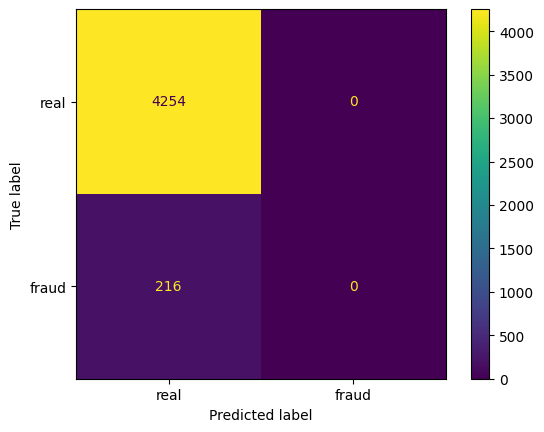

In [33]:
ConfusionMatrixDisplay.from_predictions(y_test, base_preds, display_labels=['real', 'fraud']);

In [34]:
print(classification_report(y_test, base_preds, target_names=['real', 'fraud'], zero_division=0))

              precision    recall  f1-score   support

        real       0.95      1.00      0.98      4254
       fraud       0.00      0.00      0.00       216

    accuracy                           0.95      4470
   macro avg       0.48      0.50      0.49      4470
weighted avg       0.91      0.95      0.93      4470



In [52]:
scores_base = {
    'model': 'base',
    'accuracy': accuracy_score(y_test, base_preds),
    'precision': precision_score(y_test, base_preds, zero_division=0),
    'recall': recall_score(y_test, base_preds),
    'f1-score': f1_score(y_test, base_preds),
    'roc-auc-score': roc_auc_score(y_test, base_preds)
}

scores_base

{'model': 'base',
 'accuracy': 0.9516778523489933,
 'precision': 0.0,
 'recall': 0.0,
 'f1-score': 0.0,
 'roc-auc-score': 0.5}

Although the base model has an over all accuracy of 0.95168, the other metrics are terrible: precision, recall, and the F1-score are all 0.  With an roc-auc score of 0.5.

Accuracy tells us how many of the 

## Model 1: Basic Logistic Regression, no penalty, with CountVectorizer

In [36]:
model_log = Pipeline([
    ('ct', ColumnTransformer([
        ('cvec', CountVectorizer(ngram_range=(1,2)), 'job_ad'),
        ('ohe', OneHotEncoder(drop='first'), ['employment_type', 'required_experience']),
    ], remainder= 'passthrough', force_int_remainder_cols=False)),
    ('log', LogisticRegression(penalty=None))
])

In [37]:
model_log.fit(X_train, y_train)

Pipeline(steps=[('ct',
                 ColumnTransformer(force_int_remainder_cols=False,
                                   remainder='passthrough',
                                   transformers=[('cvec',
                                                  CountVectorizer(ngram_range=(1,
                                                                               2)),
                                                  'job_ad'),
                                                 ('ohe',
                                                  OneHotEncoder(drop='first'),
                                                  ['employment_type',
                                                   'required_experience'])])),
                ('log', LogisticRegression(penalty=None))])

/var/folders/ty/qfl4p5vd2d3cxdrb54zzgq9w0000gn/T/ipykernel_4814/872255800.py:43: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig_cm.show()



Classification Report: 

              precision    recall  f1-score   support

        real       0.99      0.99      0.99      4254
  fraudulent       0.88      0.78      0.83       216

    accuracy                           0.98      4470
   macro avg       0.94      0.89      0.91      4470
weighted avg       0.98      0.98      0.98      4470



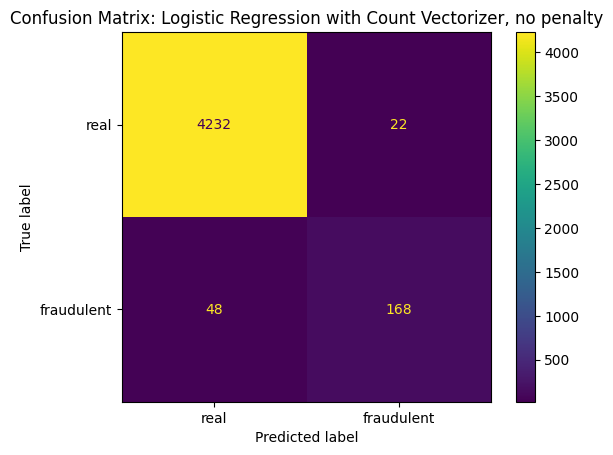

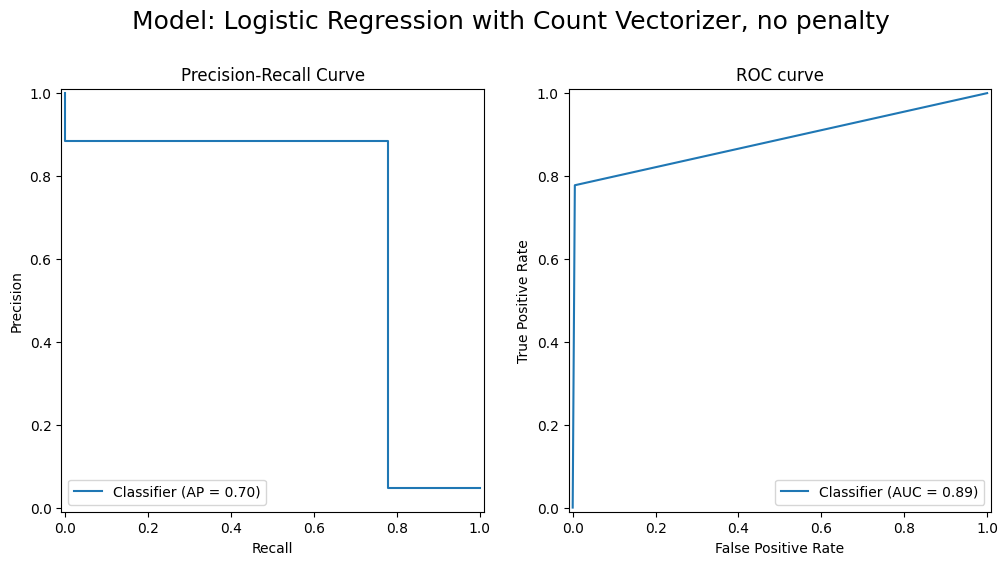

In [38]:
scores_log_cv, res_log_cv = evaluate_model(
    model_log, 
    X_test, 
    y_test, 
    fig_subtitle= 'Logistic Regression with Count Vectorizer, no penalty', 
    short_name='log_cv', 
    save_figs=True,
    return_misclassified = False,
    return_all_results = True
)

In [39]:
save_model(model_log, 'model_count_log')

In [40]:
res_log_cv.to_csv('../data/results/res_log_cv.csv')

In [41]:
scores_log_cv

{'model': 'log_cv',
 'accuracy': 0.9843400447427293,
 'precision': 0.8842105263157894,
 'recall': 0.7777777777777778,
 'f1-score': 0.8275862068965517,
 'roc-auc-score': 0.8863030872903933}

## Model 1B: Logistic Regression with TF-IDF Vectorizer

In [42]:
model_log_tfidf = Pipeline([
    ('ct', ColumnTransformer([
        ('tfidf', TfidfVectorizer(ngram_range=(1,2)), 'job_ad'),
        ('ohe', OneHotEncoder(drop='first'), ['employment_type', 'required_experience']),
    ], remainder= 'passthrough', force_int_remainder_cols=False)),
    ('log', LogisticRegression(penalty=None))
])

In [43]:
model_log_tfidf.fit(X_train, y_train)

Pipeline(steps=[('ct',
                 ColumnTransformer(force_int_remainder_cols=False,
                                   remainder='passthrough',
                                   transformers=[('tfidf',
                                                  TfidfVectorizer(ngram_range=(1,
                                                                               2)),
                                                  'job_ad'),
                                                 ('ohe',
                                                  OneHotEncoder(drop='first'),
                                                  ['employment_type',
                                                   'required_experience'])])),
                ('log', LogisticRegression(penalty=None))])


Classification Report: 

              precision    recall  f1-score   support

        real       0.99      0.99      0.99      4254
  fraudulent       0.87      0.80      0.83       216

    accuracy                           0.98      4470
   macro avg       0.93      0.90      0.91      4470
weighted avg       0.98      0.98      0.98      4470



/var/folders/ty/qfl4p5vd2d3cxdrb54zzgq9w0000gn/T/ipykernel_4814/872255800.py:43: UserWarning:

FigureCanvasAgg is non-interactive, and thus cannot be shown



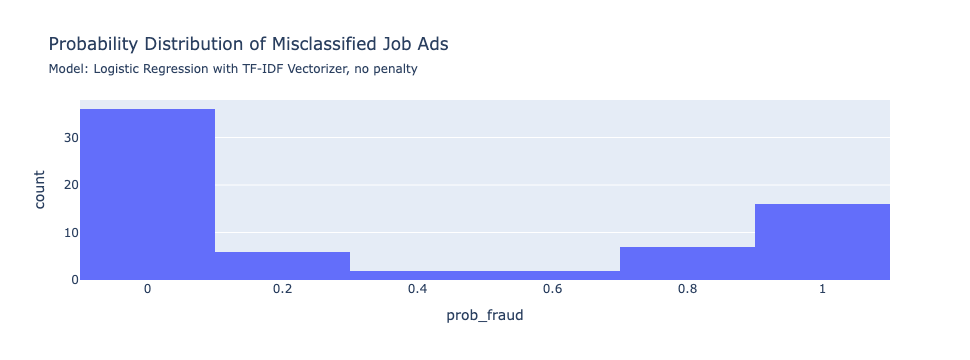

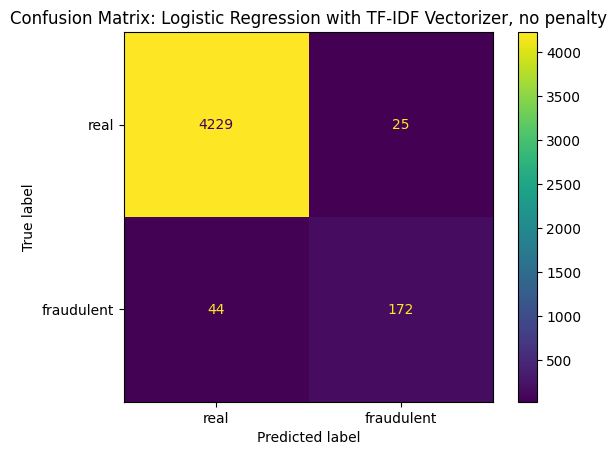

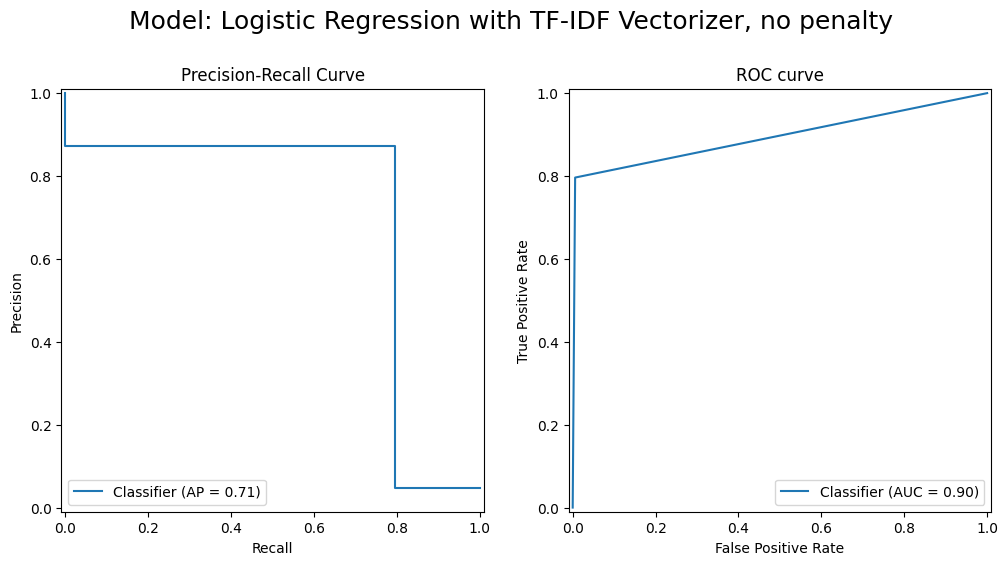

In [44]:
scores_log_tfidf, res_log_tfidf = evaluate_model(
    model_log_tfidf, 
    X_test, 
    y_test, 
    fig_subtitle= 'Logistic Regression with TF-IDF Vectorizer, no penalty', 
    short_name='log_tfidf', 
    save_figs=True,
    return_misclassified = False,
    return_all_results = True
)

In [45]:
save_model(model_log_tfidf, 'model_tfidf_log')

In [46]:
res_log_tfidf.to_csv('../data/results/res_log_tfidf.csv')

In [47]:
scores_log_tfidf

{'model': 'log_tfidf',
 'accuracy': 0.9845637583892617,
 'precision': 0.8730964467005076,
 'recall': 0.7962962962962963,
 'f1-score': 0.8329297820823245,
 'roc-auc-score': 0.8952097372407668}

## Preprocess Comparision

In [58]:
pd.DataFrame([scores_base, scores_log_cv, scores_log_tfidf]).style.apply(
    highlight_max, props='color:white; background-color:darkblue', axis=0, 
    subset=['accuracy', 'precision', 'recall', 'f1-score', 'roc-auc-score']
)

,model,accuracy,precision,recall,f1-score,roc-auc-score
0,base,0.951678,0.000000,0.000000,0.000000,0.500000
1,log_cv,0.984340,0.884211,0.777778,0.827586,0.886303
2,log_tfidf,0.984564,0.873096,0.796296,0.832930,0.895210


## Model 2: Logistic Regression, no penalty, with Count Vectorizer, add PCA

### Base Model

In [156]:
model_log_pca = Pipeline([
    ('ct', ColumnTransformer([
        ('cvec', CountVectorizer(ngram_range=(1,2)), 'job_ad'),
        ('ohe', OneHotEncoder(drop='first'), ['employment_type', 'required_experience']),
    ], remainder= 'passthrough', force_int_remainder_cols=False)),
    ('pca', PCA(n_components=100)),
    ('log', LogisticRegression(penalty=None))
])

In [157]:
model_log_pca.fit(X_train, y_train)

/Users/erindepree/venvs/dsb_602/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



Pipeline(steps=[('ct',
                 ColumnTransformer(force_int_remainder_cols=False,
                                   remainder='passthrough',
                                   transformers=[('cvec',
                                                  CountVectorizer(ngram_range=(1,
                                                                               2)),
                                                  'job_ad'),
                                                 ('ohe',
                                                  OneHotEncoder(drop='first'),
                                                  ['employment_type',
                                                   'required_experience'])])),
                ('pca', PCA(n_components=100)),
                ('log', LogisticRegression(penalty=None))])


Classification Report: 

              precision    recall  f1-score   support

        real       0.97      1.00      0.98      4253
  fraudulent       0.81      0.30      0.44       217

    accuracy                           0.96      4470
   macro avg       0.89      0.65      0.71      4470
weighted avg       0.96      0.96      0.95      4470



/var/folders/ty/qfl4p5vd2d3cxdrb54zzgq9w0000gn/T/ipykernel_39070/3203830892.py:37: UserWarning:

FigureCanvasAgg is non-interactive, and thus cannot be shown



{'model': 'log',
 'accuracy': 0.9626398210290827,
 'precision': 0.8125,
 'recall': 0.2995391705069124,
 'f1-score': 0.4377104377104377,
 'roc-auc-score': 0.6480061241671642}

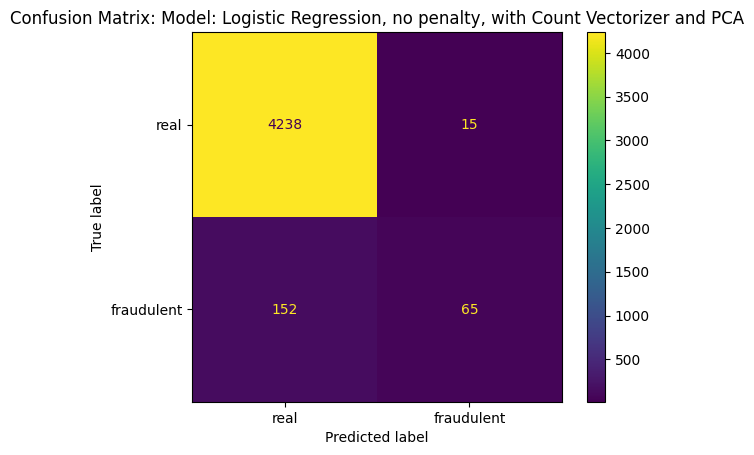

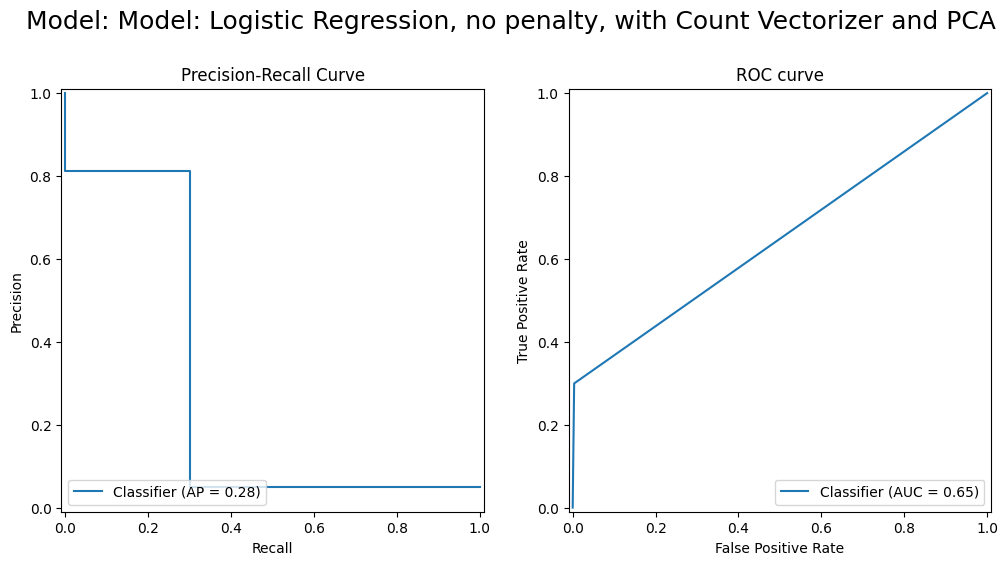

In [158]:
evaluate_model(model_log_pca, X_test, y_test, 
               fig_subtitle= 'Model: Logistic Regression, no penalty, with Count Vectorizer and PCA', short_name='log')

This is heading in the right direction, the misclassified job ads are less certain than they were previously.  

### Increase max iterations

In [159]:
model_log_pca = Pipeline([
    ('ct', ColumnTransformer([
        ('cvec', CountVectorizer(ngram_range=(1,2)), 'job_ad'),
        ('ohe', OneHotEncoder(drop='first'), ['employment_type', 'required_experience']),
    ], remainder= 'passthrough', force_int_remainder_cols=False)),
    ('pca', PCA(n_components=100)),
    ('log', LogisticRegression(penalty=None, max_iter=500))
])

In [160]:
model_log_pca.fit(X_train, y_train)

Pipeline(steps=[('ct',
                 ColumnTransformer(force_int_remainder_cols=False,
                                   remainder='passthrough',
                                   transformers=[('cvec',
                                                  CountVectorizer(ngram_range=(1,
                                                                               2)),
                                                  'job_ad'),
                                                 ('ohe',
                                                  OneHotEncoder(drop='first'),
                                                  ['employment_type',
                                                   'required_experience'])])),
                ('pca', PCA(n_components=100)),
                ('log', LogisticRegression(max_iter=500, penalty=None))])


Classification Report: 

              precision    recall  f1-score   support

        real       0.97      1.00      0.98      4253
  fraudulent       0.83      0.29      0.44       217

    accuracy                           0.96      4470
   macro avg       0.90      0.65      0.71      4470
weighted avg       0.96      0.96      0.95      4470



/var/folders/ty/qfl4p5vd2d3cxdrb54zzgq9w0000gn/T/ipykernel_39070/3203830892.py:37: UserWarning:

FigureCanvasAgg is non-interactive, and thus cannot be shown



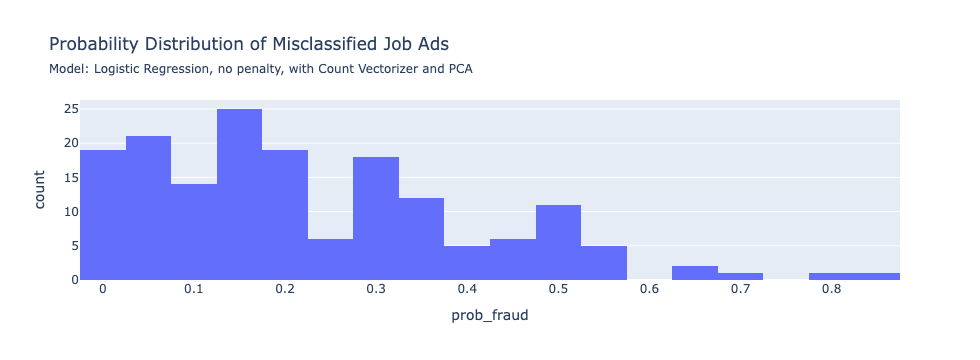

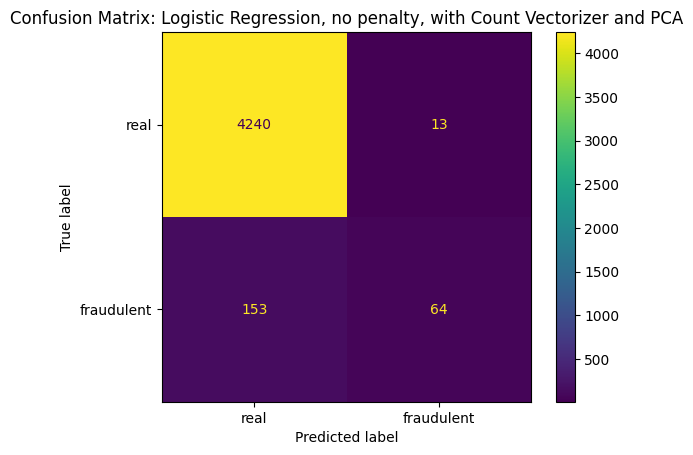

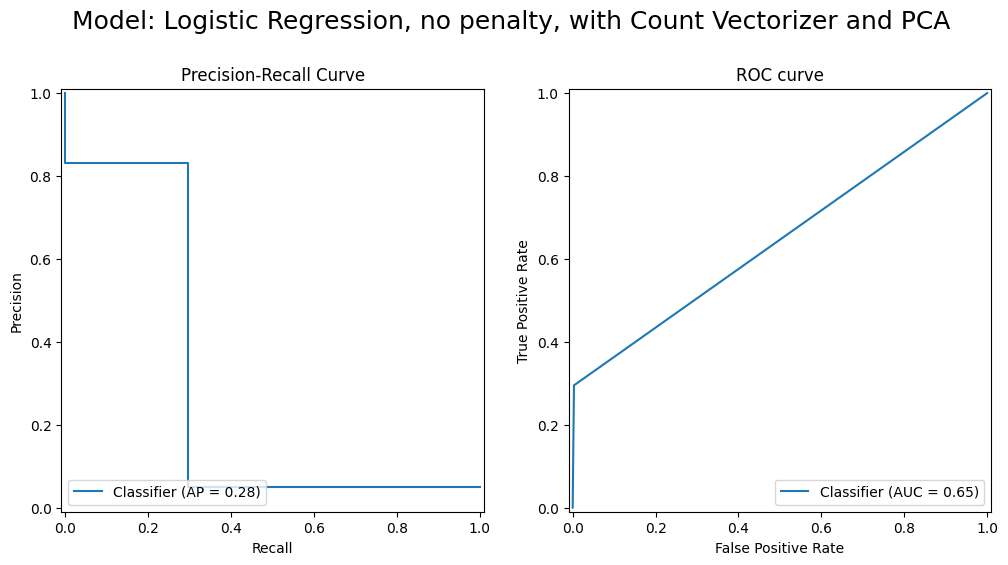

In [172]:
scores_log_cv_pca, res_log_cv_pca = evaluate_model(
    model_log_pca, X_test, y_test, 
    fig_subtitle= 'Logistic Regression, no penalty, with Count Vectorizer and PCA', 
    short_name='log_cv_pca', 
    save_figs=True,
    return_misclassified = False,
    return_all_results = True
)

In [163]:
save_model(model_log_pca, 'model_cv_pca_log')

In [164]:
res_log_cv_pca.to_csv('../data/results/res_log_cv_pca.csv')

### Changing PCA number of components

#### 200 Components

In [165]:
model_log_pca_200 = Pipeline([
    ('ct', ColumnTransformer([
        ('cvec', CountVectorizer(ngram_range=(1,2)), 'job_ad'),
        ('ohe', OneHotEncoder(drop='first'), ['employment_type', 'required_experience']),
    ], remainder= 'passthrough', force_int_remainder_cols=False)),
    ('pca', PCA(n_components=200)),
    ('log', LogisticRegression(penalty=None, max_iter=500))
])

In [166]:
model_log_pca_200.fit(X_train, y_train)

Pipeline(steps=[('ct',
                 ColumnTransformer(force_int_remainder_cols=False,
                                   remainder='passthrough',
                                   transformers=[('cvec',
                                                  CountVectorizer(ngram_range=(1,
                                                                               2)),
                                                  'job_ad'),
                                                 ('ohe',
                                                  OneHotEncoder(drop='first'),
                                                  ['employment_type',
                                                   'required_experience'])])),
                ('pca', PCA(n_components=200)),
                ('log', LogisticRegression(max_iter=500, penalty=None))])


Classification Report: 

              precision    recall  f1-score   support

        real       0.97      1.00      0.98      4253
  fraudulent       0.86      0.44      0.58       217

    accuracy                           0.97      4470
   macro avg       0.91      0.72      0.78      4470
weighted avg       0.97      0.97      0.96      4470



/var/folders/ty/qfl4p5vd2d3cxdrb54zzgq9w0000gn/T/ipykernel_39070/3203830892.py:37: UserWarning:

FigureCanvasAgg is non-interactive, and thus cannot be shown



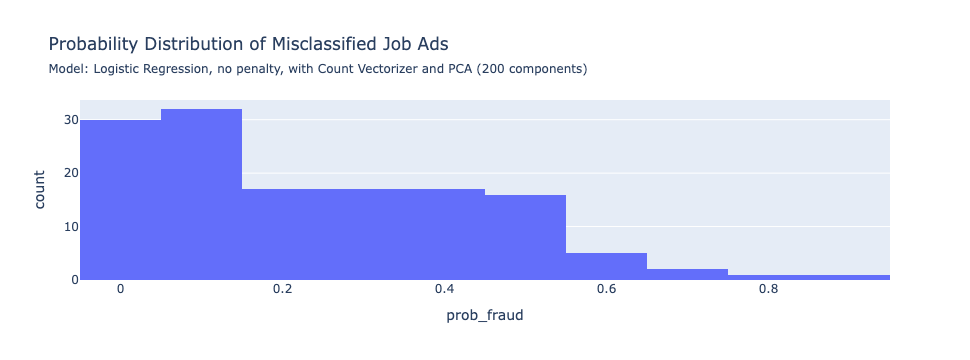

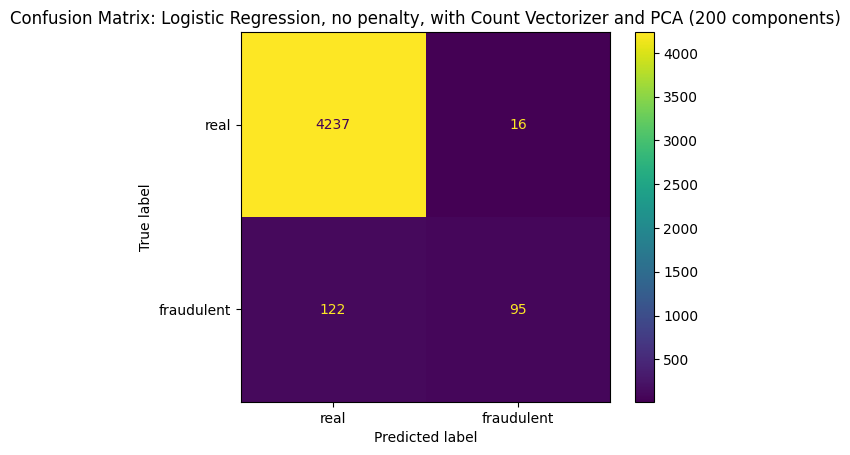

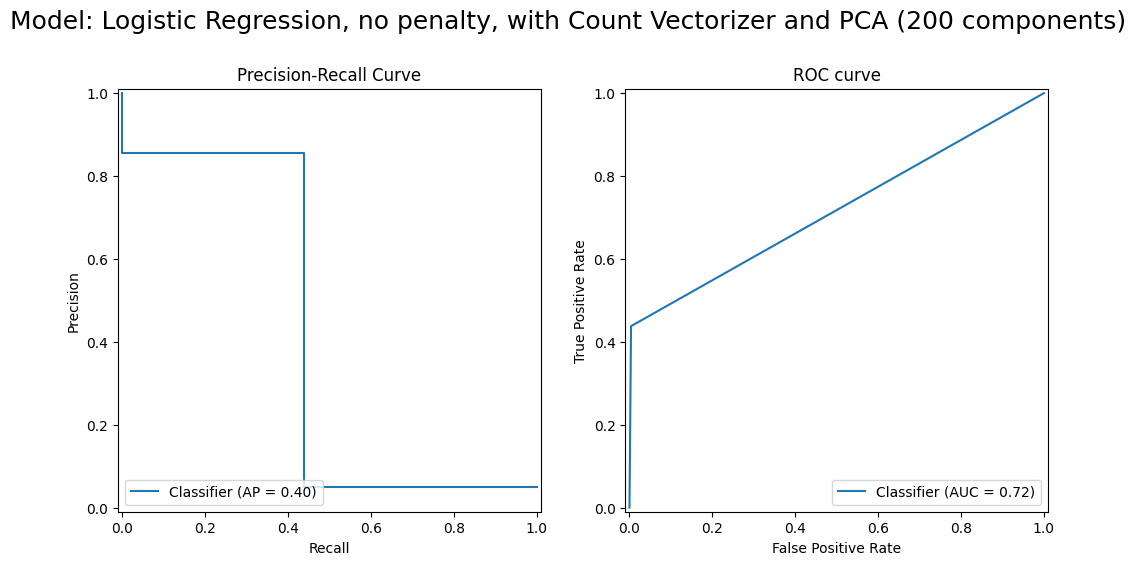

In [179]:
scores_log_cv_pca_200, res_log_cv_pca_200 = evaluate_model(
    model_log_pca_200, X_test, y_test, 
    fig_subtitle= 'Logistic Regression, no penalty, with Count Vectorizer and PCA (200 components)', 
    short_name='log_cv_pca_200', 
    save_figs=True,
    return_misclassified = False,
    return_all_results = True
)

In [180]:
save_model(model_log_pca_200, 'model_log_cv_pca_200')

In [181]:
res_log_cv_pca_200.to_csv('../data/results/res_log_cv_pca_200.csv')

In [182]:
scores_log_cv_pca_200

{'model': 'log_cv_pca_200',
 'accuracy': 0.9691275167785235,
 'precision': 0.8558558558558559,
 'recall': 0.4377880184331797,
 'f1-score': 0.5792682926829268,
 'roc-auc-score': 0.7170129840578783}

#### 300 Components

In [173]:
model_log_pca_300 = Pipeline([
    ('ct', ColumnTransformer([
        ('cvec', CountVectorizer(ngram_range=(1,2)), 'job_ad'),
        ('ohe', OneHotEncoder(drop='first'), ['employment_type', 'required_experience']),
    ], remainder= 'passthrough', force_int_remainder_cols=False)),
    ('pca', PCA(n_components=300)),
    ('log', LogisticRegression(penalty=None, max_iter=500))
])

In [174]:
model_log_pca_300.fit(X_train, y_train)

Pipeline(steps=[('ct',
                 ColumnTransformer(force_int_remainder_cols=False,
                                   remainder='passthrough',
                                   transformers=[('cvec',
                                                  CountVectorizer(ngram_range=(1,
                                                                               2)),
                                                  'job_ad'),
                                                 ('ohe',
                                                  OneHotEncoder(drop='first'),
                                                  ['employment_type',
                                                   'required_experience'])])),
                ('pca', PCA(n_components=300)),
                ('log', LogisticRegression(max_iter=500, penalty=None))])


Classification Report: 

              precision    recall  f1-score   support

        real       0.98      0.99      0.98      4253
  fraudulent       0.78      0.53      0.63       217

    accuracy                           0.97      4470
   macro avg       0.88      0.76      0.81      4470
weighted avg       0.97      0.97      0.97      4470



/var/folders/ty/qfl4p5vd2d3cxdrb54zzgq9w0000gn/T/ipykernel_39070/3203830892.py:37: UserWarning:

FigureCanvasAgg is non-interactive, and thus cannot be shown



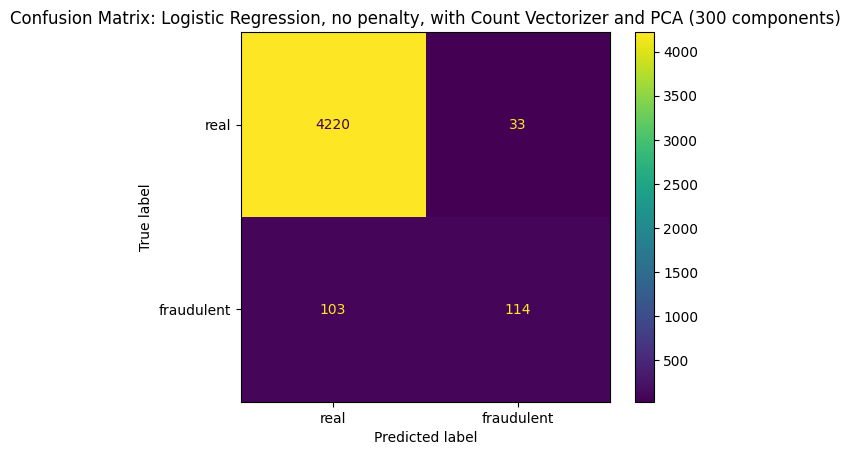

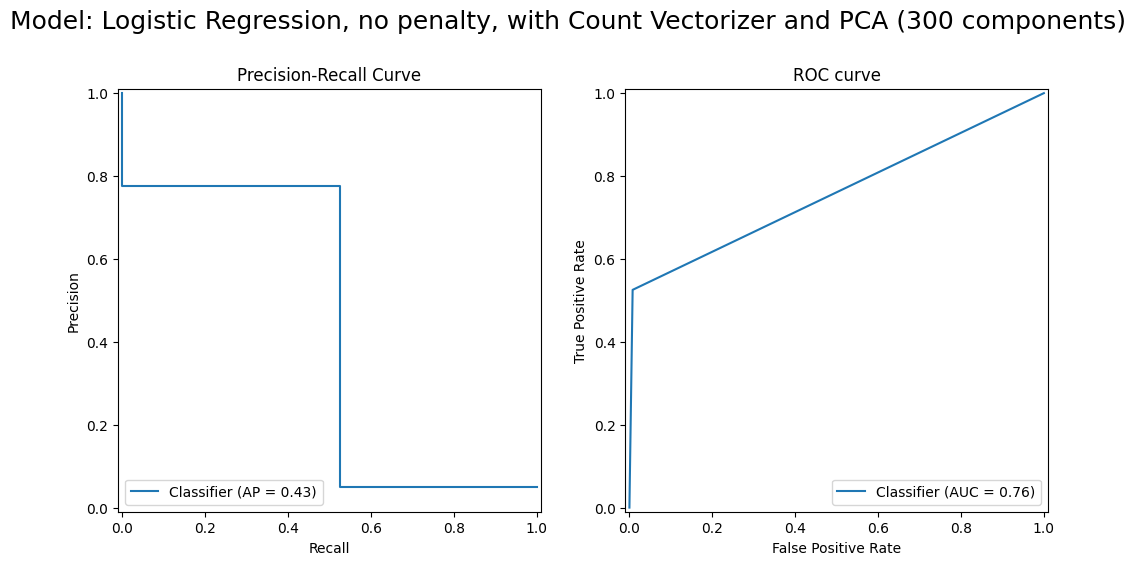

In [175]:
scores_log_cv_pca_300, res_log_cv_pca_300 = evaluate_model(
    model_log_pca_300, X_test, y_test, 
    fig_subtitle= 'Logistic Regression, no penalty, with Count Vectorizer and PCA (300 components)', 
    short_name='log_cv_pca_300', 
    save_figs=True,
    return_misclassified = False,
    return_all_results = True
)

In [176]:
save_model(model_log_pca_300, 'model_log_cv_pca_300')

In [177]:
res_log_cv_pca_300.to_csv('../data/results/res_log_cv_pca_300.csv')

In [178]:
scores_log_cv_pca_300

{'model': 'log_cv_pca_300',
 'accuracy': 0.9695749440715884,
 'precision': 0.7755102040816326,
 'recall': 0.5253456221198156,
 'f1-score': 0.6263736263736264,
 'roc-auc-score': 0.7587931966700654}

#### 500 components

In [183]:
model_log_pca_500 = Pipeline([
    ('ct', ColumnTransformer([
        ('cvec', CountVectorizer(ngram_range=(1,2)), 'job_ad'),
        ('ohe', OneHotEncoder(drop='first'), ['employment_type', 'required_experience']),
    ], remainder= 'passthrough', force_int_remainder_cols=False)),
    ('pca', PCA(n_components=500)),
    ('log', LogisticRegression(penalty=None, max_iter=500))
])

In [184]:
model_log_pca_500.fit(X_train, y_train)

Pipeline(steps=[('ct',
                 ColumnTransformer(force_int_remainder_cols=False,
                                   remainder='passthrough',
                                   transformers=[('cvec',
                                                  CountVectorizer(ngram_range=(1,
                                                                               2)),
                                                  'job_ad'),
                                                 ('ohe',
                                                  OneHotEncoder(drop='first'),
                                                  ['employment_type',
                                                   'required_experience'])])),
                ('pca', PCA(n_components=500)),
                ('log', LogisticRegression(max_iter=500, penalty=None))])


Classification Report: 

              precision    recall  f1-score   support

        real       0.98      0.99      0.99      4253
  fraudulent       0.72      0.68      0.70       217

    accuracy                           0.97      4470
   macro avg       0.85      0.83      0.84      4470
weighted avg       0.97      0.97      0.97      4470



/var/folders/ty/qfl4p5vd2d3cxdrb54zzgq9w0000gn/T/ipykernel_39070/3203830892.py:37: UserWarning:

FigureCanvasAgg is non-interactive, and thus cannot be shown



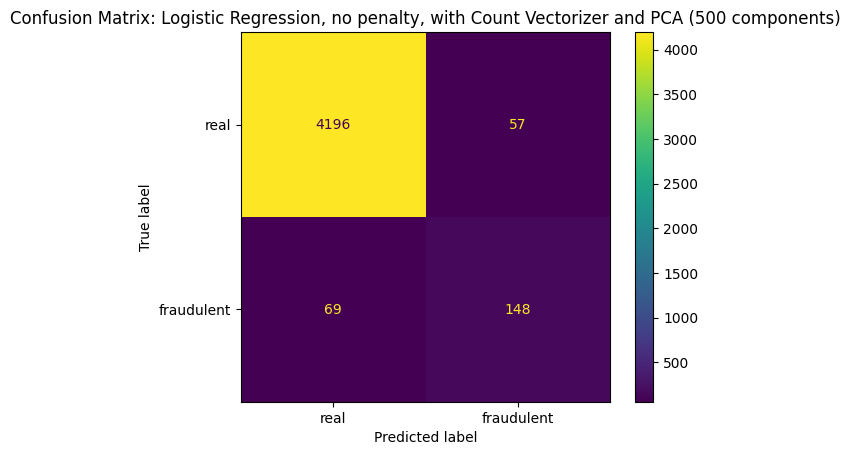

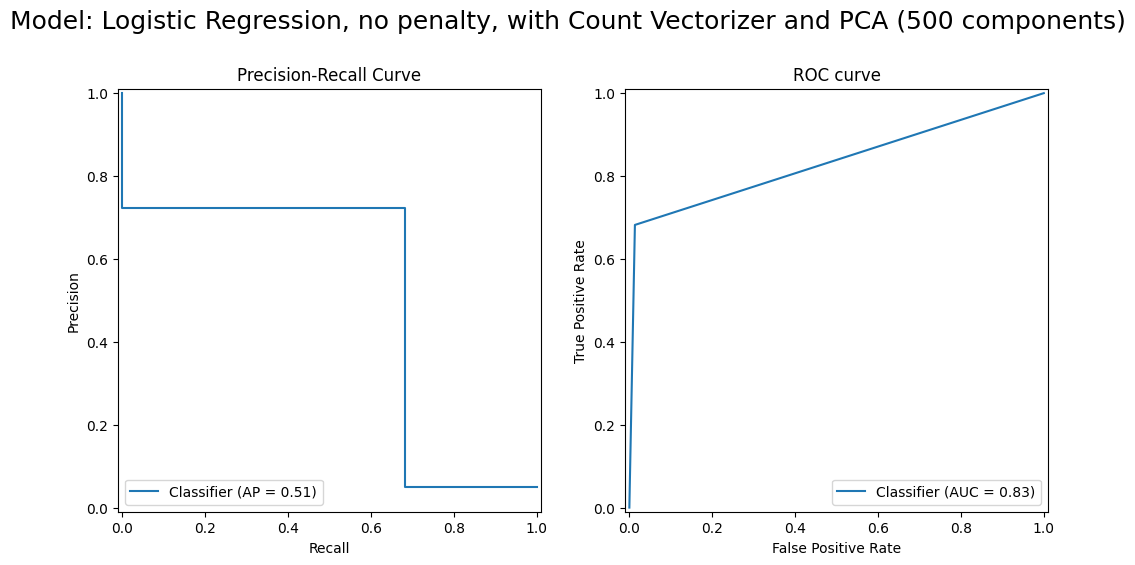

In [185]:
scores_log_cv_pca_500, res_log_cv_pca_500 = evaluate_model(
    model_log_pca_500, X_test, y_test, 
    fig_subtitle= 'Logistic Regression, no penalty, with Count Vectorizer and PCA (500 components)', 
    short_name='log_cv_pca_500', 
    save_figs=True,
    return_misclassified = False,
    return_all_results = True
)

In [186]:
save_model(model_log_pca_500, 'model_log_pca_500')

In [187]:
res_log_cv_pca_500.to_csv('../data/results/res_log_cv_pca_500.csv')

In [188]:
scores_log_cv_pca_500

{'model': 'log_cv_pca_500',
 'accuracy': 0.9718120805369127,
 'precision': 0.7219512195121951,
 'recall': 0.6820276497695853,
 'f1-score': 0.7014218009478673,
 'roc-auc-score': 0.8343126727568829}

### Excluding Stop Words

Comments on stop words, pros and cons.

In [52]:
model_log_pca_stop = Pipeline([
    ('ct', ColumnTransformer([
        ('cvec', CountVectorizer(ngram_range=(1,2), stop_words = 'english'), 'job_ad'),
        ('ohe', OneHotEncoder(drop='first'), ['employment_type', 'required_experience']),
    ], remainder= 'passthrough', force_int_remainder_cols=False)),
    ('pca', PCA(n_components=200)),
    ('log', LogisticRegression(penalty=None, max_iter=500))
])

In [53]:
model_log_pca_stop.fit(X_train, y_train)

Pipeline(steps=[('ct',
                 ColumnTransformer(force_int_remainder_cols=False,
                                   remainder='passthrough',
                                   transformers=[('cvec',
                                                  CountVectorizer(ngram_range=(1,
                                                                               2),
                                                                  stop_words='english'),
                                                  'job_ad'),
                                                 ('ohe',
                                                  OneHotEncoder(drop='first'),
                                                  ['employment_type',
                                                   'required_experience'])])),
                ('pca', PCA(n_components=200)),
                ('log', LogisticRegression(max_iter=500, penalty=None))])


Classification Report: 

              precision    recall  f1-score   support

        real       0.97      1.00      0.98      4253
  fraudulent       0.85      0.41      0.55       217

    accuracy                           0.97      4470
   macro avg       0.91      0.70      0.77      4470
weighted avg       0.96      0.97      0.96      4470



/var/folders/ty/qfl4p5vd2d3cxdrb54zzgq9w0000gn/T/ipykernel_39070/3203830892.py:37: UserWarning:

FigureCanvasAgg is non-interactive, and thus cannot be shown



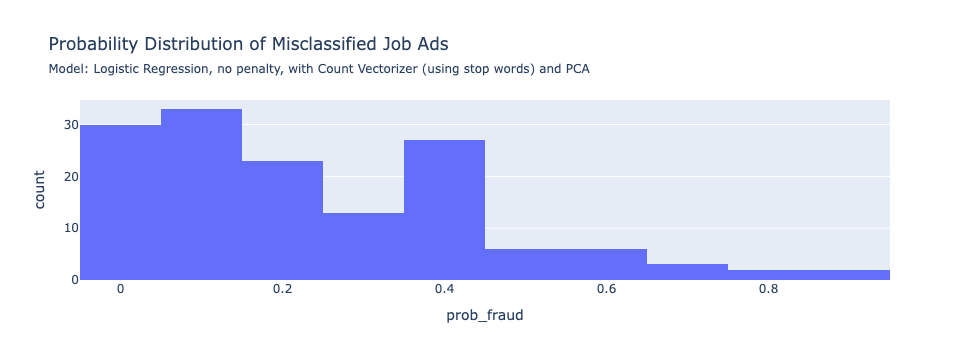

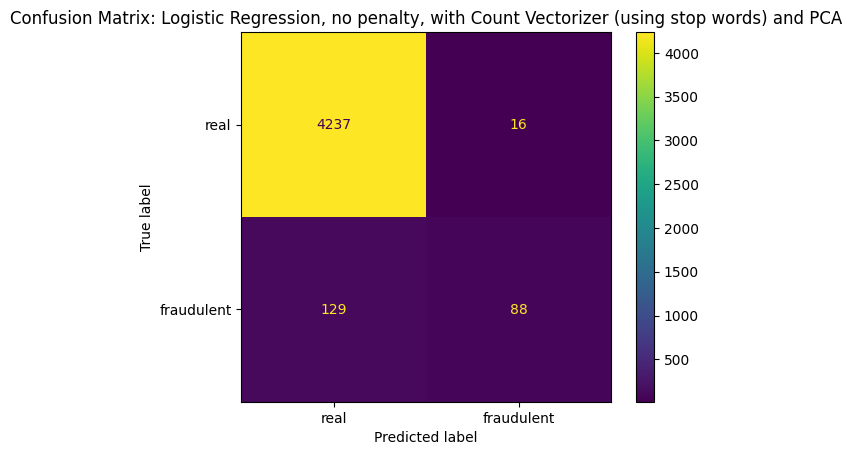

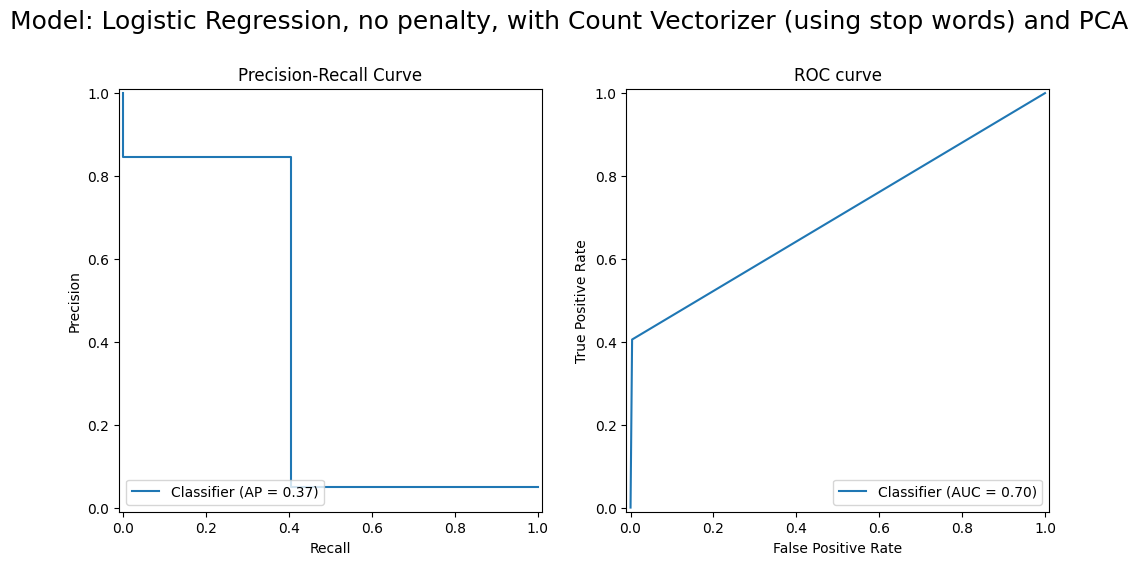

In [189]:
scores_log_cv_pca_stop, res_log_cv_pca_stop = evaluate_model(
    model_log_pca_stop, X_test, y_test, 
    fig_subtitle= 'Logistic Regression, no penalty, with Count Vectorizer (using stop words) and PCA', 
    short_name='log_cv_pca_stop', 
    save_figs=True,
    return_misclassified = False,
    return_all_results = True
)

In [191]:
res_log_cv_pca_stop.to_csv('../data/results/res_log_cv_pca_stop.csv')

In [192]:
save_model(model_log_pca_stop, 'model_log_cv_pca_stop')

In [193]:
scores_log_cv_pca_stop

{'model': 'log_cv_pca_stop',
 'accuracy': 0.9675615212527964,
 'precision': 0.8461538461538461,
 'recall': 0.4055299539170507,
 'f1-score': 0.5482866043613707,
 'roc-auc-score': 0.7008839517998138}

without PCA

In [194]:
model_log_stop = Pipeline([
    ('ct', ColumnTransformer([
        ('cvec', CountVectorizer(ngram_range=(1,2), stop_words= 'english'), 'job_ad'),
        ('ohe', OneHotEncoder(drop='first'), ['employment_type', 'required_experience']),
    ], remainder= 'passthrough', force_int_remainder_cols=False)),
    ('log', LogisticRegression(penalty=None, max_iter=500))
])

In [195]:
model_log_stop.fit(X_train, y_train)

Pipeline(steps=[('ct',
                 ColumnTransformer(force_int_remainder_cols=False,
                                   remainder='passthrough',
                                   transformers=[('cvec',
                                                  CountVectorizer(ngram_range=(1,
                                                                               2),
                                                                  stop_words='english'),
                                                  'job_ad'),
                                                 ('ohe',
                                                  OneHotEncoder(drop='first'),
                                                  ['employment_type',
                                                   'required_experience'])])),
                ('log', LogisticRegression(max_iter=500, penalty=None))])


Classification Report: 

              precision    recall  f1-score   support

        real       0.99      1.00      0.99      4253
  fraudulent       0.92      0.77      0.84       217

    accuracy                           0.99      4470
   macro avg       0.96      0.88      0.92      4470
weighted avg       0.99      0.99      0.99      4470



/var/folders/ty/qfl4p5vd2d3cxdrb54zzgq9w0000gn/T/ipykernel_39070/3203830892.py:37: UserWarning:

FigureCanvasAgg is non-interactive, and thus cannot be shown



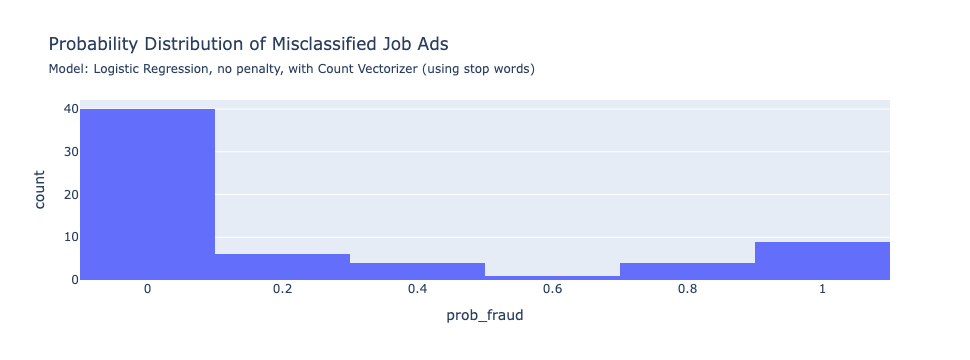

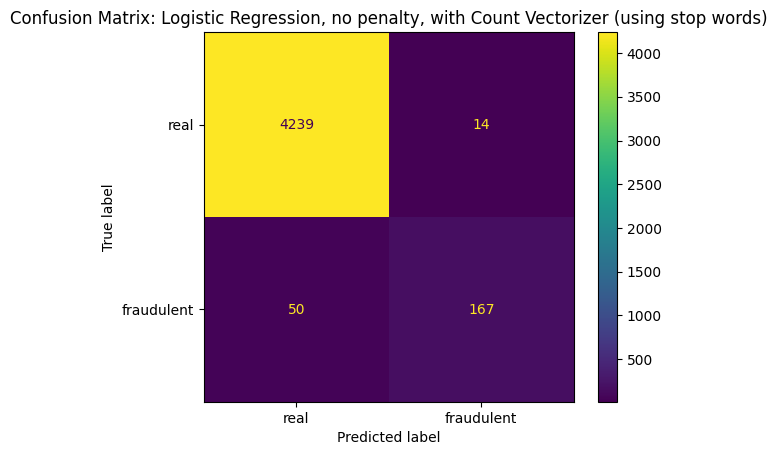

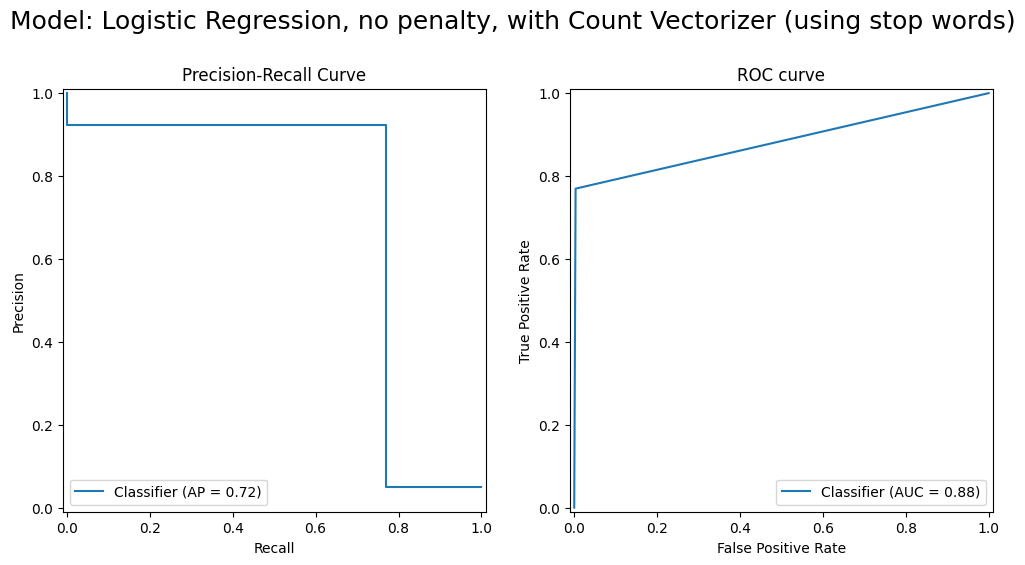

In [196]:
scores_log_cv_stop, res_log_cv_stop = evaluate_model(
    model_log_stop, X_test, y_test, 
    fig_subtitle= 'Logistic Regression, no penalty, with Count Vectorizer (using stop words)', 
    short_name='log_cv_stop', 
    save_figs=True,
    return_misclassified = False,
    return_all_results = True
)

In [197]:
save_model(model_log_stop)

TypeError: save_model() missing 1 required positional argument: 'filename'

In [ ]:
res_log_cv_stop.to_csv('../data/results/res_log_cv_stop.csv')

In [ ]:
scores_log_cv_stop

## Model 2B: Logistic Regression, no penalty, with TF-IDF Vectorizer, add PCA

### Base Model

In [60]:
model_log_tfidf_pca = Pipeline([
    ('ct', ColumnTransformer([
        ('tfidf', TfidfVectorizer(ngram_range=(1,2)), 'job_ad'),
        ('ohe', OneHotEncoder(drop='first'), ['employment_type', 'required_experience']),
    ], remainder= 'passthrough', force_int_remainder_cols=False)),
    ('pca', PCA(n_components=100)),
    ('log', LogisticRegression(penalty=None, max_iter= 500))
])

In [61]:
model_log_tfidf_pca.fit(X_train, y_train)

Pipeline(steps=[('ct',
                 ColumnTransformer(force_int_remainder_cols=False,
                                   remainder='passthrough',
                                   transformers=[('tfidf',
                                                  TfidfVectorizer(ngram_range=(1,
                                                                               2)),
                                                  'job_ad'),
                                                 ('ohe',
                                                  OneHotEncoder(drop='first'),
                                                  ['employment_type',
                                                   'required_experience'])])),
                ('pca', PCA(n_components=100)),
                ('log', LogisticRegression(max_iter=500, penalty=None))])


Classification Report: 

              precision    recall  f1-score   support

        real       0.97      1.00      0.98      4253
  fraudulent       0.84      0.41      0.55       217

    accuracy                           0.97      4470
   macro avg       0.90      0.70      0.76      4470
weighted avg       0.96      0.97      0.96      4470



/var/folders/ty/qfl4p5vd2d3cxdrb54zzgq9w0000gn/T/ipykernel_39070/3203830892.py:37: UserWarning:

FigureCanvasAgg is non-interactive, and thus cannot be shown



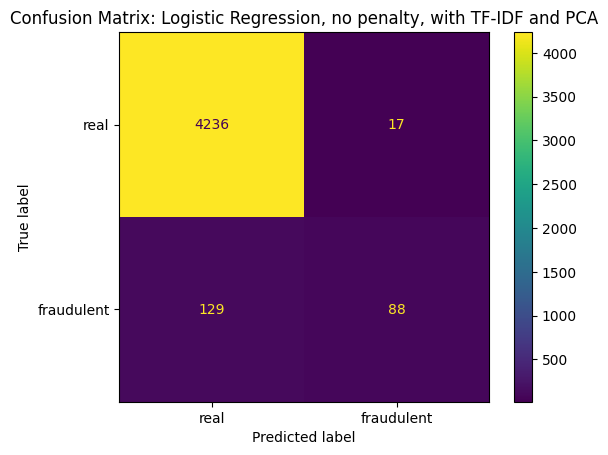

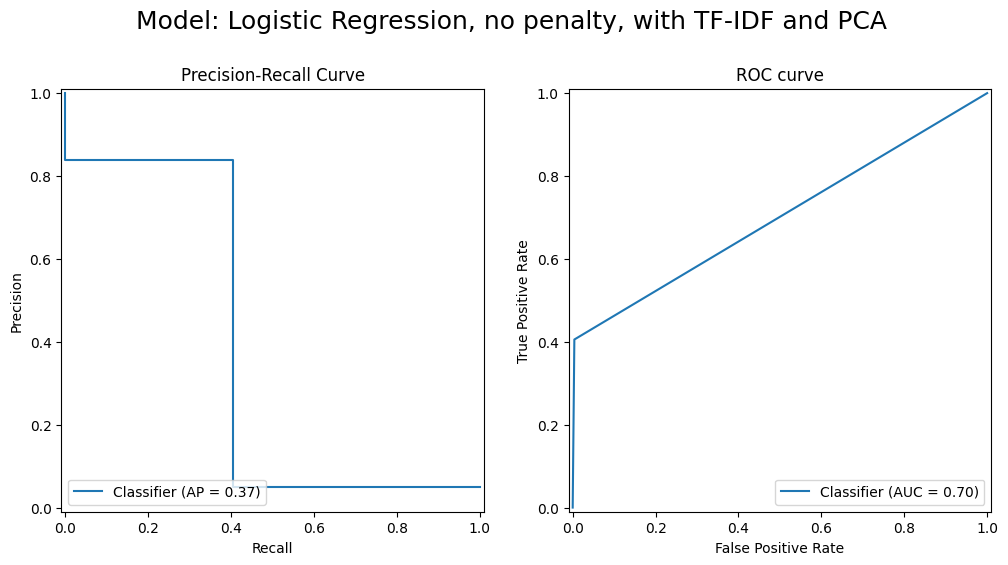

In [198]:
scores_log_tfidf_pca, res_log_tfidf_pca = evaluate_model(
    model_log_tfidf_pca, X_test, y_test, 
    fig_subtitle= 'Logistic Regression, no penalty, with TF-IDF and PCA', 
    short_name='log_tfidf_pca', 
    save_figs=True,
    return_misclassified = False,
    return_all_results = True
)

In [199]:
save_model(model_log_tfidf_pca, 'model_log_tfidf_pca')

In [200]:
res_log_tfidf_pca.to_csv('../data/results/res_log_tfidf_pca.csv')

In [201]:
scores_log_tfidf_pca

{'model': 'log_tfidf_pca',
 'accuracy': 0.967337807606264,
 'precision': 0.8380952380952381,
 'recall': 0.4055299539170507,
 'f1-score': 0.546583850931677,
 'roc-auc-score': 0.7007663877273944}

## Models 3: Logistic Regression with Regularization

### Ridge Regularization

In [202]:
model_log_tfidf_ridge_pca = Pipeline([
    ('ct', ColumnTransformer([
        ('tfidf', TfidfVectorizer(ngram_range=(1,2)), 'job_ad'),
        ('ohe', OneHotEncoder(drop='first'), ['employment_type', 'required_experience']),
    ], remainder= 'passthrough', force_int_remainder_cols=False)),
    ('pca', PCA(n_components=100)),
    ('log', LogisticRegression(penalty='l2', C=0.1, max_iter= 500))
])

In [203]:
model_log_tfidf_ridge_pca.fit(X_train, y_train)

Pipeline(steps=[('ct',
                 ColumnTransformer(force_int_remainder_cols=False,
                                   remainder='passthrough',
                                   transformers=[('tfidf',
                                                  TfidfVectorizer(ngram_range=(1,
                                                                               2)),
                                                  'job_ad'),
                                                 ('ohe',
                                                  OneHotEncoder(drop='first'),
                                                  ['employment_type',
                                                   'required_experience'])])),
                ('pca', PCA(n_components=100)),
                ('log', LogisticRegression(C=0.1, max_iter=500))])


Classification Report: 

              precision    recall  f1-score   support

        real       0.95      1.00      0.98      4253
  fraudulent       1.00      0.02      0.05       217

    accuracy                           0.95      4470
   macro avg       0.98      0.51      0.51      4470
weighted avg       0.95      0.95      0.93      4470



/var/folders/ty/qfl4p5vd2d3cxdrb54zzgq9w0000gn/T/ipykernel_39070/3203830892.py:37: UserWarning:

FigureCanvasAgg is non-interactive, and thus cannot be shown



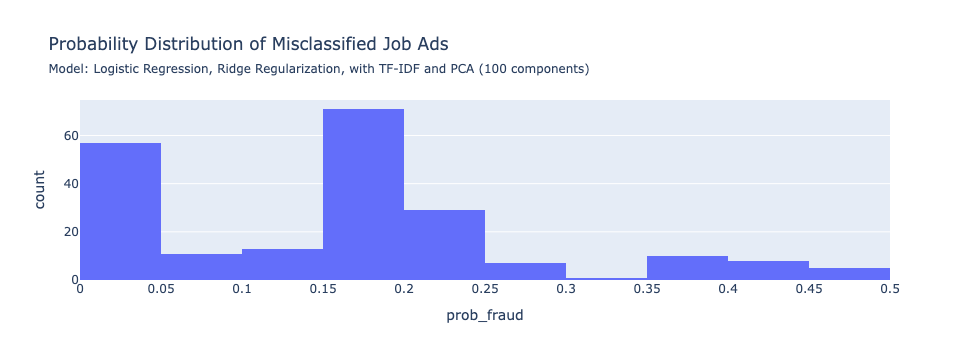

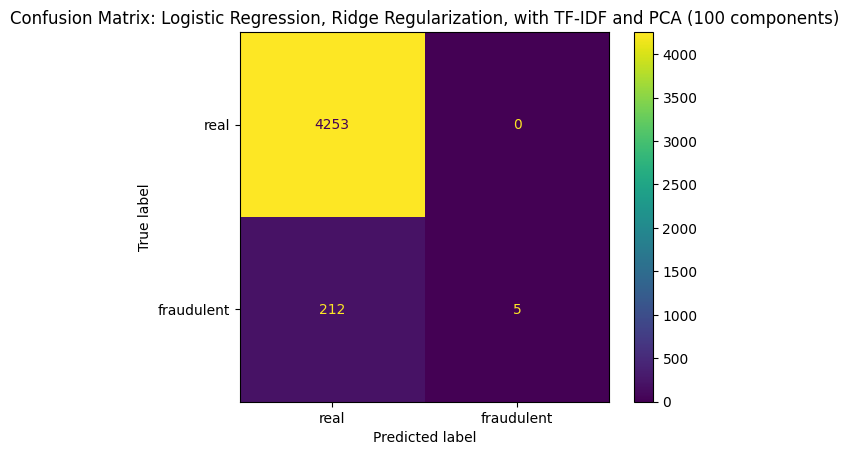

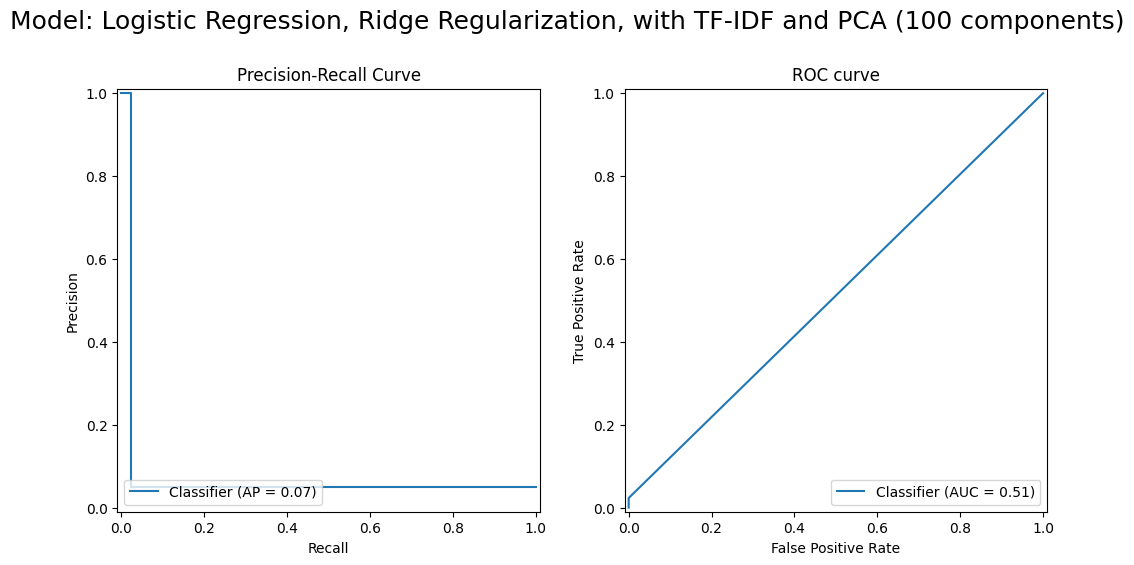

In [204]:
scores_log_tfidf_ridge_pca, res_log_tfidf_ridge_pca = evaluate_model(
    model_log_ridge_pca, X_test, y_test, 
    fig_subtitle= 'Logistic Regression, Ridge Regularization, with TF-IDF and PCA (100 components)', 
    short_name='log_tfidf_ridge_pca', 
    save_figs=True,
    return_misclassified = False,
    return_all_results = True
)

In [206]:
save_model(model_log_tfidf_ridge_pca, 'model_log_tfidf_ridge_pca')

In [207]:
res_log_tfidf_ridge_pca.to_csv('../data/results/res_log_tfidf_ridge_pca.csv')

In [208]:
scores_log_tfidf_ridge_pca

{'model': 'log_tfidf_ridge_pca',
 'accuracy': 0.9525727069351231,
 'precision': 1.0,
 'recall': 0.02304147465437788,
 'f1-score': 0.04504504504504504,
 'roc-auc-score': 0.511520737327189}

### LASSO Regularization

In [209]:
model_log_tfidf_lasso_pca = Pipeline([
    ('ct', ColumnTransformer([
        ('tfidf', TfidfVectorizer(ngram_range=(1,2)), 'job_ad'),
        ('ohe', OneHotEncoder(drop='first'), ['employment_type', 'required_experience']),
    ], remainder= 'passthrough', force_int_remainder_cols=False)),
    ('pca', PCA(n_components=100)),
    ('log', LogisticRegression(penalty='l1', C=0.1, max_iter= 500, solver='liblinear'))
])

In [210]:
model_log_tfidf_lasso_pca.fit(X_train, y_train)

Pipeline(steps=[('ct',
                 ColumnTransformer(force_int_remainder_cols=False,
                                   remainder='passthrough',
                                   transformers=[('tfidf',
                                                  TfidfVectorizer(ngram_range=(1,
                                                                               2)),
                                                  'job_ad'),
                                                 ('ohe',
                                                  OneHotEncoder(drop='first'),
                                                  ['employment_type',
                                                   'required_experience'])])),
                ('pca', PCA(n_components=100)),
                ('log',
                 LogisticRegression(C=0.1, max_iter=500, penalty='l1',
                                    solver='liblinear'))])


Classification Report: 

              precision    recall  f1-score   support

        real       0.95      1.00      0.98      4253
  fraudulent       1.00      0.06      0.11       217

    accuracy                           0.95      4470
   macro avg       0.98      0.53      0.54      4470
weighted avg       0.96      0.95      0.93      4470



/var/folders/ty/qfl4p5vd2d3cxdrb54zzgq9w0000gn/T/ipykernel_39070/3203830892.py:37: UserWarning:

FigureCanvasAgg is non-interactive, and thus cannot be shown



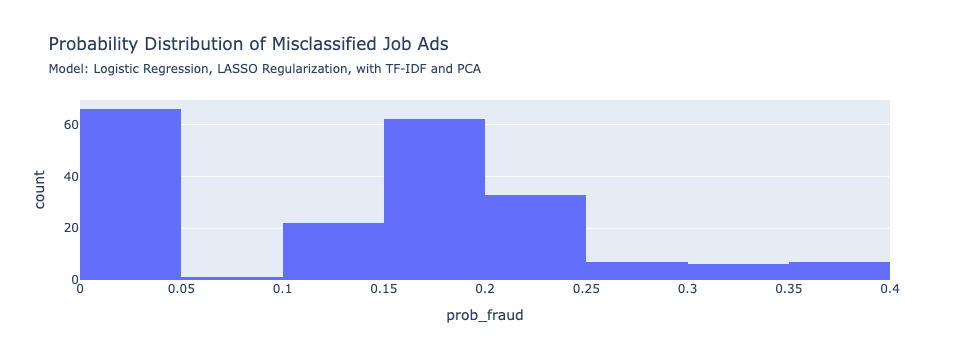

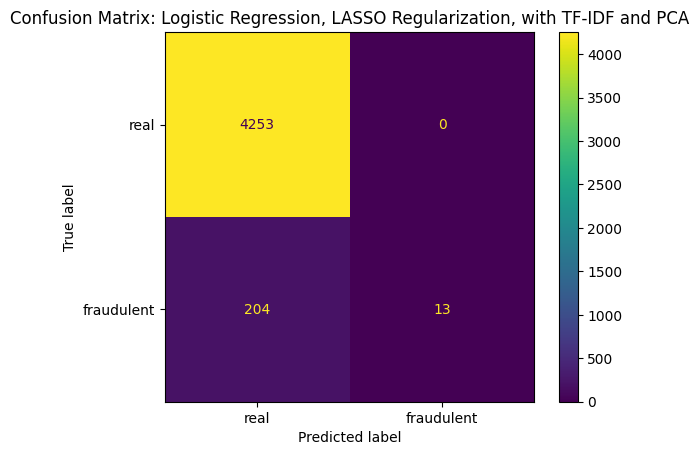

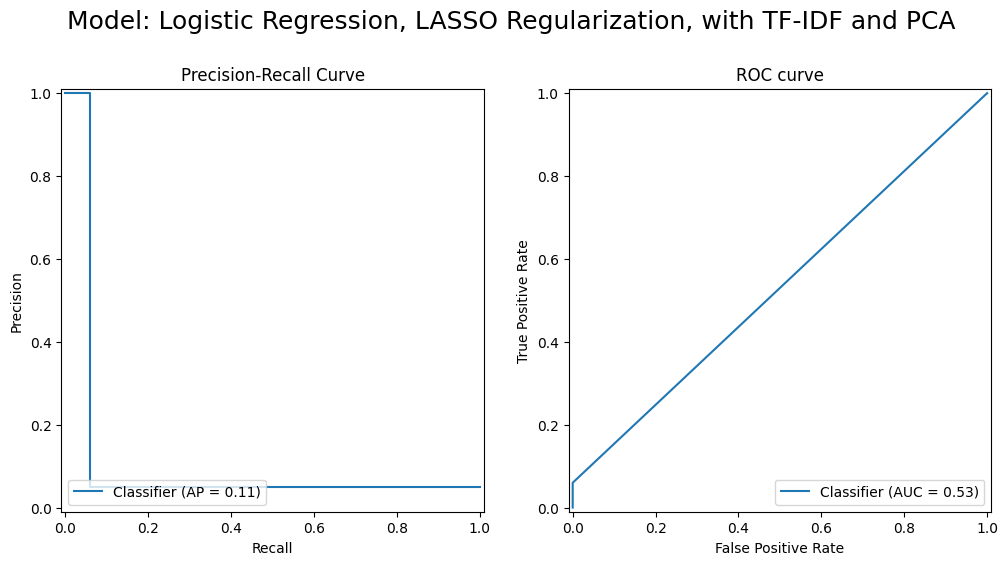

In [211]:
scores_log_tfidf_lasso_pca, res_log_tfidf_lasso_pca = evaluate_model(
    model_log_tfidf_lasso_pca, X_test, y_test, 
    fig_subtitle= 'Logistic Regression, LASSO Regularization, with TF-IDF and PCA', 
    short_name='log_tfidf_lasso_pca', 
    save_figs=True,
    return_misclassified = False,
    return_all_results = True
)

In [212]:
save_model(model_log_tfidf_lasso_pca, 'model_log_tfidf_lasso_pca')

In [213]:
res_log_tfidf_lasso_pca.to_csv('../data/results/res_log_tfidf_lasso_pca.csv')

In [214]:
scores_log_tfidf_lasso_pca

{'model': 'log_tfidf_lasso_pca',
 'accuracy': 0.9543624161073826,
 'precision': 1.0,
 'recall': 0.059907834101382486,
 'f1-score': 0.11304347826086956,
 'roc-auc-score': 0.5299539170506913}

## Random Forest Models

In [215]:
model_random_tfidf_pca = Pipeline([
    ('ct', ColumnTransformer([
        ('tfidf', TfidfVectorizer(ngram_range=(1,2)), 'job_ad'),
        ('ohe', OneHotEncoder(drop='first'), ['employment_type', 'required_experience']),
    ], remainder= 'passthrough', force_int_remainder_cols=False)),
    ('pca', PCA(n_components=100)),
    ('forest', RandomForestClassifier(n_estimators=500, max_depth=10, max_features='sqrt', ))
])

In [216]:
model_random_tfidf_pca.fit(X_train, y_train)

Pipeline(steps=[('ct',
                 ColumnTransformer(force_int_remainder_cols=False,
                                   remainder='passthrough',
                                   transformers=[('tfidf',
                                                  TfidfVectorizer(ngram_range=(1,
                                                                               2)),
                                                  'job_ad'),
                                                 ('ohe',
                                                  OneHotEncoder(drop='first'),
                                                  ['employment_type',
                                                   'required_experience'])])),
                ('pca', PCA(n_components=100)),
                ('forest',
                 RandomForestClassifier(max_depth=10, n_estimators=500))])


Classification Report: 

              precision    recall  f1-score   support

        real       0.97      1.00      0.98      4253
  fraudulent       1.00      0.32      0.49       217

    accuracy                           0.97      4470
   macro avg       0.98      0.66      0.74      4470
weighted avg       0.97      0.97      0.96      4470



/var/folders/ty/qfl4p5vd2d3cxdrb54zzgq9w0000gn/T/ipykernel_39070/3203830892.py:37: UserWarning:

FigureCanvasAgg is non-interactive, and thus cannot be shown



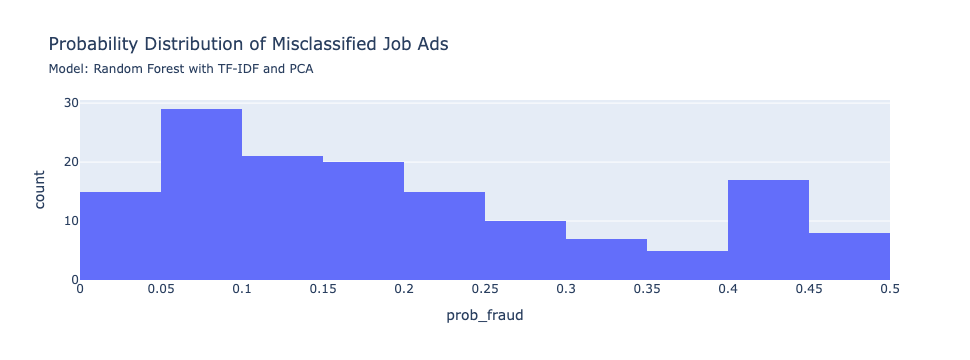

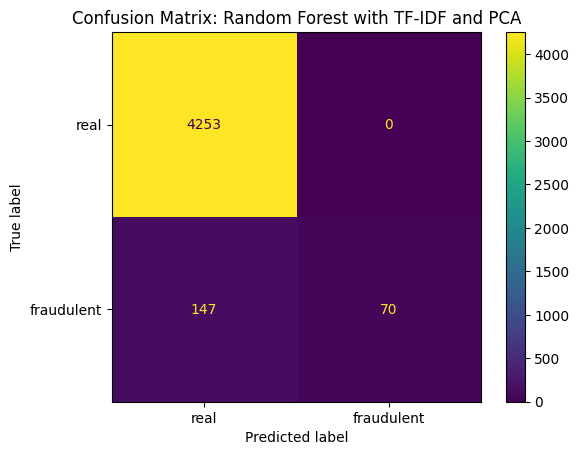

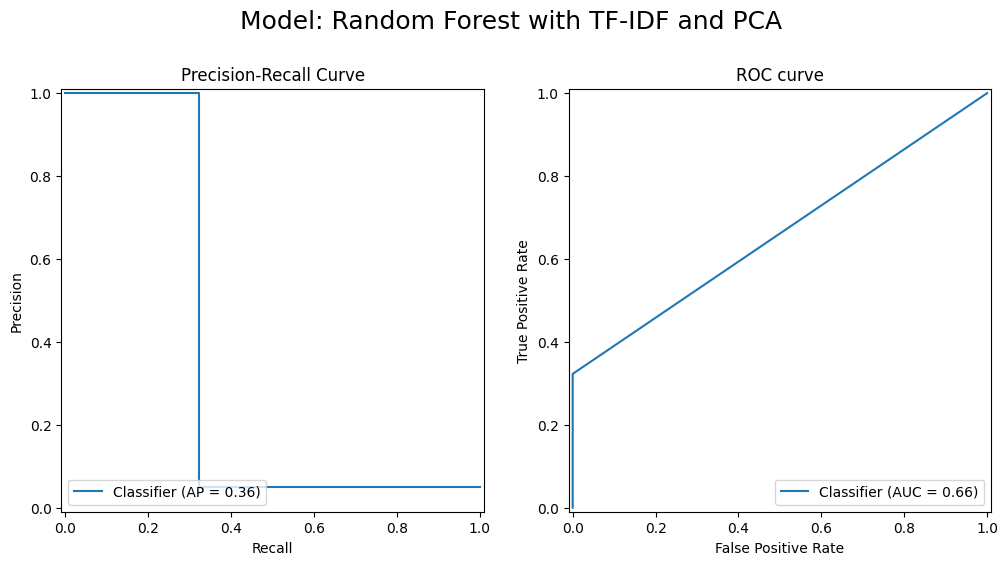

In [217]:
scores_random_tfidf_pca, res_random_tfidf_pca = evaluate_model(
    model_random_tfidf_pca, X_test, y_test, 
    fig_subtitle= 'Random Forest with TF-IDF and PCA', 
    short_name='random_tfidf_pca', 
    save_figs=True,
    return_misclassified = False,
    return_all_results = True
)

In [218]:
save_model(model_random_tfidf_pca, 'model_random_tfidf_pca')

In [220]:
res_random_tfidf_pca.to_csv('../data/results/res_random_tfidf_pca.csv')

In [221]:
scores_random_tfidf_pca

{'model': 'random_tfidf_pca',
 'accuracy': 0.9671140939597316,
 'precision': 1.0,
 'recall': 0.3225806451612903,
 'f1-score': 0.4878048780487805,
 'roc-auc-score': 0.6612903225806451}

### Explore Parameter Space

In [26]:
model_random_gs = Pipeline([
    ('ct', ColumnTransformer([
        ('tfidf', TfidfVectorizer(ngram_range=(1,2)), 'job_ad'),
        ('ohe', OneHotEncoder(drop='first'), ['employment_type', 'required_experience']),
    ], remainder= 'passthrough', force_int_remainder_cols=False)),
    ('pca', PCA(n_components=100)),
    ('forest', RandomForestClassifier())
])

In [27]:
random_params = {
    'forest__n_estimators': [500],
    'forest__max_features': ['sqrt', 1.0, 0.5, 0.3],
    'forest__max_samples': [1],
    'forest__max_depth': [10, 20],
    'forest__min_samples_split': [3,10],
}

In [28]:
grid_forest = GridSearchCV(model_random_gs, param_grid=random_params)

In [29]:
grid_forest.fit(X_train, y_train)

GridSearchCV(estimator=Pipeline(steps=[('ct',
                                        ColumnTransformer(force_int_remainder_cols=False,
                                                          remainder='passthrough',
                                                          transformers=[('tfidf',
                                                                         TfidfVectorizer(ngram_range=(1,
                                                                                                      2)),
                                                                         'job_ad'),
                                                                        ('ohe',
                                                                         OneHotEncoder(drop='first'),
                                                                         ['employment_type',
                                                                          'required_experience'])])),
                                       ('pca', PCA(n_components=100)),
                                       ('forest', RandomForestClassifier())]),
             param_grid={'forest__max_depth': [10, 20],
                         'forest__max_features': ['sqrt', 1.0, 0.5, 0.3],
                         'forest__max_samples': [1],
                         'forest__min_samples_split': [3, 10],
                         'forest__n_estimators': [500]})

In [30]:
grid_forest.best_score_
grid_forest.best_params_

{'forest__max_depth': 10,
 'forest__max_features': 'sqrt',
 'forest__max_samples': 1,
 'forest__min_samples_split': 3,
 'forest__n_estimators': 500}


Classification Report: 

              precision    recall  f1-score   support

        real       0.95      1.00      0.98      4254
  fraudulent       0.00      0.00      0.00       216

    accuracy                           0.95      4470
   macro avg       0.48      0.50      0.49      4470
weighted avg       0.91      0.95      0.93      4470



/Users/erindepree/venvs/dsb_602/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/Users/erindepree/venvs/dsb_602/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/Users/erindepree/venvs/dsb_602/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



,actual,predicted,prob_fraud
0,1,0,0.046
1,1,0,0.046
2,1,0,0.046
3,1,0,0.046
4,1,0,0.046
...,...,...,...
211,1,0,0.046
212,1,0,0.046
213,1,0,0.046
214,1,0,0.046


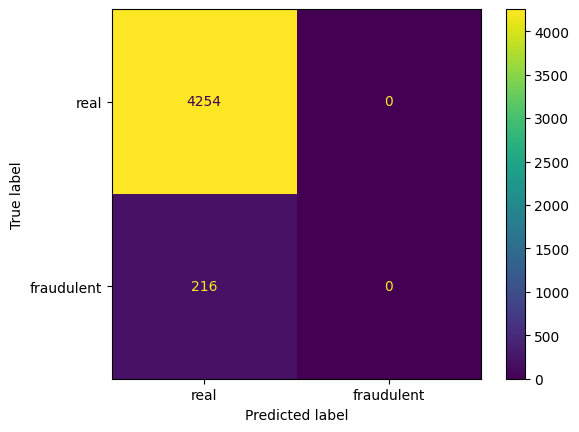

In [31]:
evaluate_model(
    grid_forest, X_test, y_test, 
    fig_subtitle= 'Model: Random Forest with TF-IDF Vectorizer and PCA, Grid Search', 
    short_name='random_grid',
    save_figs=True
)

## Naive Bayes

### Multinomial Naive Bayes Models

#### Count Vectorizer

In [222]:
model_count_bayes = Pipeline([
    ('ct', ColumnTransformer([
        ('cvec', CountVectorizer(ngram_range=(1,2)), 'job_ad'),
        ('ohe', OneHotEncoder(drop='first'), ['employment_type', 'required_experience']),
    ], remainder= 'passthrough', force_int_remainder_cols=False)),
    ('bayes', MultinomialNB())
])

In [223]:
model_count_bayes.fit(X_train, y_train)

Pipeline(steps=[('ct',
                 ColumnTransformer(force_int_remainder_cols=False,
                                   remainder='passthrough',
                                   transformers=[('cvec',
                                                  CountVectorizer(ngram_range=(1,
                                                                               2)),
                                                  'job_ad'),
                                                 ('ohe',
                                                  OneHotEncoder(drop='first'),
                                                  ['employment_type',
                                                   'required_experience'])])),
                ('bayes', MultinomialNB())])


Classification Report: 

              precision    recall  f1-score   support

        real       0.97      1.00      0.99      4253
  fraudulent       0.97      0.49      0.65       217

    accuracy                           0.97      4470
   macro avg       0.97      0.75      0.82      4470
weighted avg       0.97      0.97      0.97      4470



/var/folders/ty/qfl4p5vd2d3cxdrb54zzgq9w0000gn/T/ipykernel_39070/3203830892.py:37: UserWarning:

FigureCanvasAgg is non-interactive, and thus cannot be shown



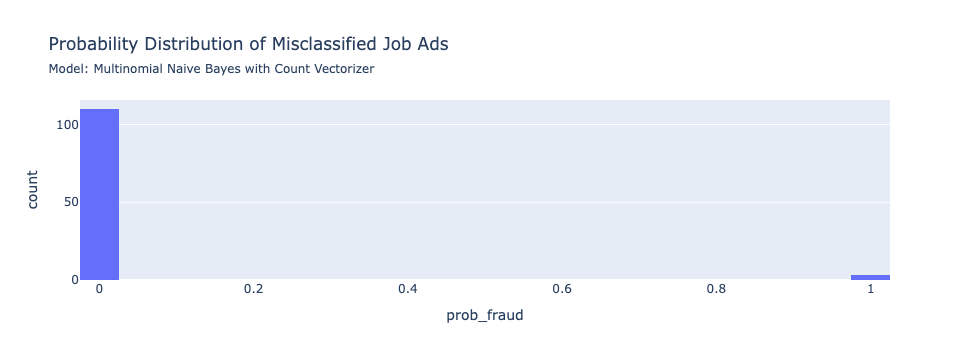

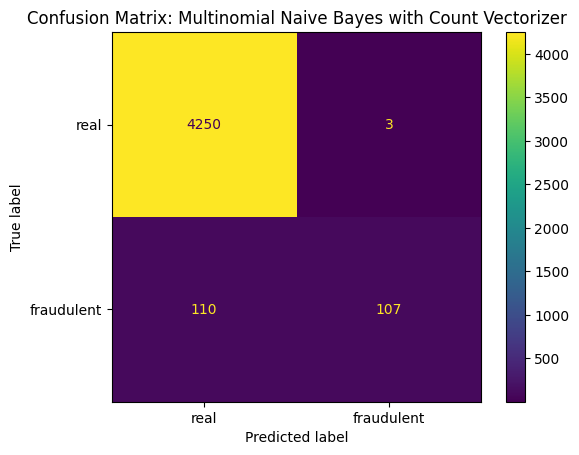

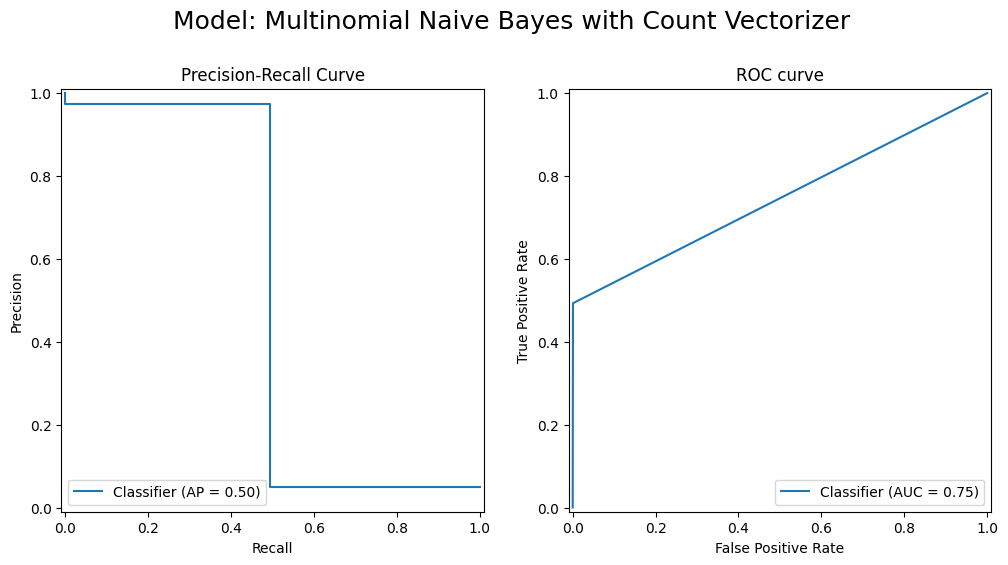

In [224]:
scores_cv_bayes, res_cv_bayes = evaluate_model(
    model_count_bayes, X_test, y_test, 
    fig_subtitle= 'Multinomial Naive Bayes with Count Vectorizer', 
    short_name='cv_bayes', 
    save_figs=True,
    return_misclassified = False,
    return_all_results = True
)

In [228]:
save_model(model_count_bayes, 'model_bayes_cv')

In [229]:
res_cv_bayes.to_csv('../data/results/res_cv_bayes.csv')

In [230]:
scores_cv_bayes

{'model': 'cv_bayes',
 'accuracy': 0.9747203579418344,
 'precision': 0.9727272727272728,
 'recall': 0.4930875576036866,
 'f1-score': 0.654434250764526,
 'roc-auc-score': 0.7461910865845849}

#### Count Vectorizer and PCA

In [226]:
model_cv_bayes_pca = Pipeline([
    ('ct', ColumnTransformer([
        ('cvec', CountVectorizer(ngram_range=(1,2)), 'job_ad'),
        ('ohe', OneHotEncoder(drop='first'), ['employment_type', 'required_experience']),
    ], remainder= 'passthrough', force_int_remainder_cols=False)),
    ('pca', PCA()),
    ('bayes', MultinomialNB())
])

In [227]:
model_cv_bayes_pca.fit(X_train, y_train)

KeyboardInterrupt: 

In [ ]:
scores_bayes_cv_pca, res_bayes_cv_pca = evaluate_model(
    model_cv_bayes_pca, X_test, y_test, 
    fig_subtitle= 'Multinomial Naive Bayes with Count Vectorizer and PCA', 
    short_name='bayes_cv_pca', 
    save_figs=True,
    return_misclassified = False,
    return_all_results = True
)

In [ ]:
save_model(model_cv_bayes_pca)

In [ ]:
res_bayes_cv_pca.to_csv('../data/results/res_bayes_cv_pca.csv')

In [ ]:
scores_bayes_cv_pca

#### TF-IDF Vectorizer

In [ ]:
model_bayes_tfidf = Pipeline([
    ('ct', ColumnTransformer([
        ('tfidf', TfidfVectorizer(ngram_range=(1,2)), 'job_ad'),
        ('ohe', OneHotEncoder(drop='first'), ['employment_type', 'required_experience']),
    ], remainder= 'passthrough', force_int_remainder_cols=False)),
    ('bayes', MultinomialNB())
])

In [ ]:
model_bayes_tfidf.fit(X_train, y_train)

In [ ]:
scores_bayes_tfidf, res_lbayes_tfidf = evaluate_model(
    model_bayes_tfidf, X_test, y_test, 
    fig_subtitle= 'Multinomial Naive Bayes with TF-IDF', 
    short_name='bayes_tfidf', 
    save_figs=True,
    return_misclassified = False,
    return_all_results = True
)

In [ ]:
save_model(model_bayes_tfidf)

In [ ]:
res_bayes_tfidf.to_csv('../data/results/res_bayes_tfidf.csv')

In [ ]:
scores_bayes_tfidf

#### TF-IDF Vectorizer and PCA

In [ ]:
model_bayes_tfidf_pca = Pipeline([
    ('ct', ColumnTransformer([
        ('tfidf', TfidfVectorizer(ngram_range=(1,2)), 'job_ad'),
        ('ohe', OneHotEncoder(drop='first'), ['employment_type', 'required_experience']),
    ], remainder= 'passthrough', force_int_remainder_cols=False)),
    ('pca', PCA()),
    ('bayes', MultinomialNB())
])

In [ ]:
model_bayes_tfidf_pca.fit(X_train, y_train)

In [ ]:
scores_bayes_tfidf_pca, res_bayes_tfidf_pca = evaluate_model(
    model_bayes_tfidf_pca, X_test, y_test, 
    fig_subtitle= 'Multinomial Naive Bayes with TF-IDF and PCA', 
    short_name='bayes_tfidf_pca', 
    save_figs=True,
    return_misclassified = False,
    return_all_results = True
)

In [ ]:
save_model(model_bayes_tfidf_pca)

In [ ]:
res_bayes_tfidf_pca.to_csv('../data/results/res_bayes_tfidf_pca.csv')

In [ ]:
scores_bayes_tfidf_pca

### Complement Naive Bayes

#### Count Vectorizer

In [231]:
model_comp_bayes_cv = Pipeline([
    ('ct', ColumnTransformer([
        ('cvec', CountVectorizer(ngram_range=(1,2)), 'job_ad'),
        ('ohe', OneHotEncoder(drop='first'), ['employment_type', 'required_experience']),
    ], remainder= 'passthrough', force_int_remainder_cols=False)),
    ('bayes', ComplementNB())
])

In [232]:
model_comp_bayes_cv.fit(X_train, y_train)

Pipeline(steps=[('ct',
                 ColumnTransformer(force_int_remainder_cols=False,
                                   remainder='passthrough',
                                   transformers=[('cvec',
                                                  CountVectorizer(ngram_range=(1,
                                                                               2)),
                                                  'job_ad'),
                                                 ('ohe',
                                                  OneHotEncoder(drop='first'),
                                                  ['employment_type',
                                                   'required_experience'])])),
                ('bayes', ComplementNB())])


Classification Report: 

              precision    recall  f1-score   support

        real       0.97      1.00      0.99      4253
  fraudulent       0.97      0.49      0.65       217

    accuracy                           0.97      4470
   macro avg       0.97      0.75      0.82      4470
weighted avg       0.97      0.97      0.97      4470



/var/folders/ty/qfl4p5vd2d3cxdrb54zzgq9w0000gn/T/ipykernel_39070/3203830892.py:37: UserWarning:

FigureCanvasAgg is non-interactive, and thus cannot be shown



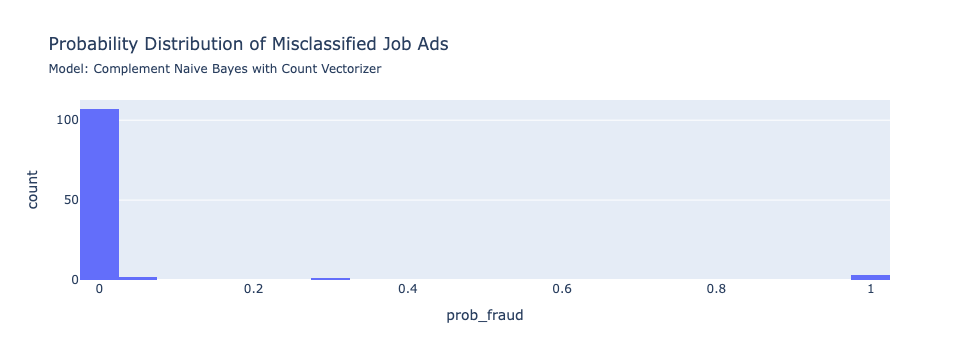

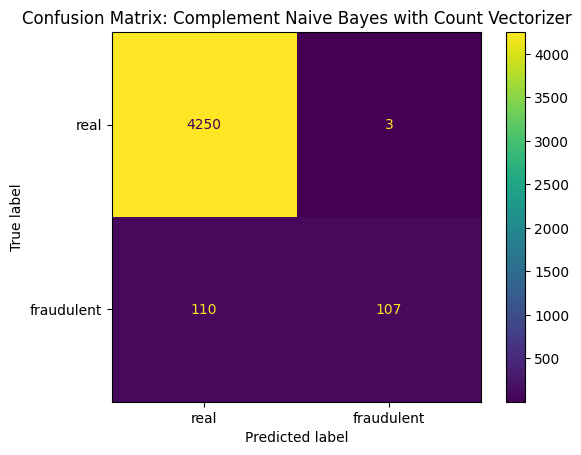

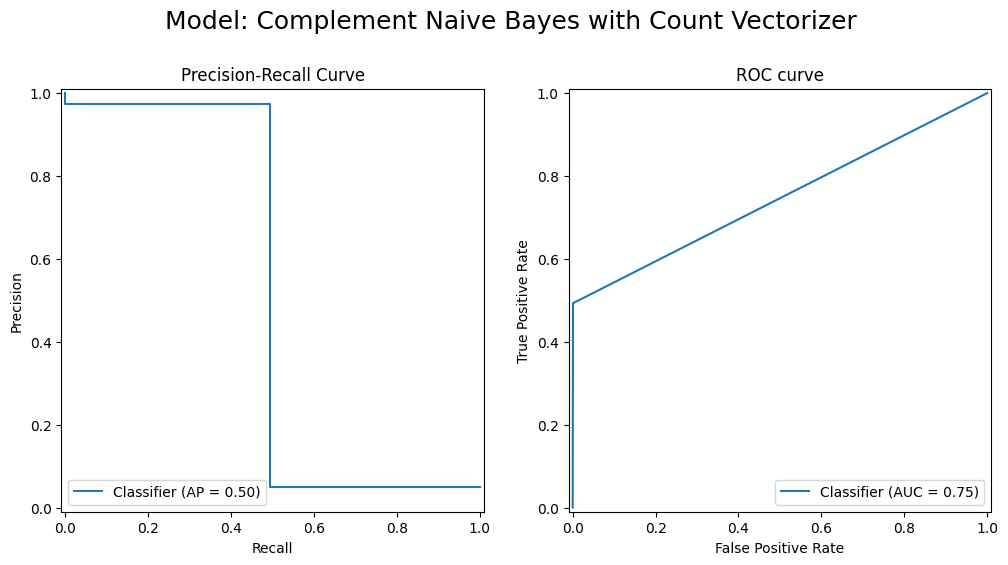

In [233]:
scores_comp_bayes_cv, res_comp_bayes_cv = evaluate_model(
    model_comp_bayes_cv, X_test, y_test, 
    fig_subtitle= 'Complement Naive Bayes with Count Vectorizer', 
    short_name='comp_bayes_cv', 
    save_figs=True,
    return_misclassified = False,
    return_all_results = True
)

In [234]:
save_model(model_comp_bayes_cv)

TypeError: save_model() missing 1 required positional argument: 'filename'

In [ ]:
res_comp_bayes_cv.to_csv('../data/results/res_comp_bayes_cv.csv')

In [ ]:
scores_comp_bayes_cv

#### Count Vectorizer and PCA

In [ ]:
model_comp_bayes_cv_pca = Pipeline([
    ('ct', ColumnTransformer([
        ('cvec', CountVectorizer(ngram_range=(1,2)), 'job_ad'),
        ('ohe', OneHotEncoder(drop='first'), ['employment_type', 'required_experience']),
    ], remainder= 'passthrough', force_int_remainder_cols=False)),
    ('pca', PCA()),
    ('bayes', ComplementNB())
])

In [ ]:
model_comp_bayes_cv_pca.fit(X_train, y_train)

In [ ]:
scores_comp_bayes_cv_pca, res_comp_bayes_cv_pca = evaluate_model(
    model_comp_bayes_cv_pca, X_test, y_test, 
    fig_subtitle= 'Complement Naive Bayes with Count Vectorizer and PCA', 
    short_name='comp_bayes_cv_pca', 
    save_figs=True,
    return_misclassified = False,
    return_all_results = True
)

In [ ]:
save_model(model_comp_bayes_cv_pca)

In [ ]:
res_comp_bayes_cv_pca.to_csv('../data/results/res_comp_bayes_cv_pca.csv')

In [ ]:
scores_comp_bayes_cv_pca

#### TF-IDF Vectorizer

In [235]:
model_comp_bayes_tfidf = Pipeline([
    ('ct', ColumnTransformer([
        ('tfidf', TfidfVectorizer(ngram_range=(1,2)), 'job_ad'),
        ('ohe', OneHotEncoder(drop='first'), ['employment_type', 'required_experience']),
    ], remainder= 'passthrough', force_int_remainder_cols=False)),
    ('bayes', ComplementNB())
])

In [236]:
model_comp_bayes_tfidf.fit(X_train, y_train)

Pipeline(steps=[('ct',
                 ColumnTransformer(force_int_remainder_cols=False,
                                   remainder='passthrough',
                                   transformers=[('tfidf',
                                                  TfidfVectorizer(ngram_range=(1,
                                                                               2)),
                                                  'job_ad'),
                                                 ('ohe',
                                                  OneHotEncoder(drop='first'),
                                                  ['employment_type',
                                                   'required_experience'])])),
                ('bayes', ComplementNB())])


Classification Report: 

              precision    recall  f1-score   support

        real       0.95      1.00      0.98      4253
  fraudulent       0.00      0.00      0.00       217

    accuracy                           0.95      4470
   macro avg       0.48      0.50      0.49      4470
weighted avg       0.91      0.95      0.93      4470



/var/folders/ty/qfl4p5vd2d3cxdrb54zzgq9w0000gn/T/ipykernel_39070/3203830892.py:37: UserWarning:

FigureCanvasAgg is non-interactive, and thus cannot be shown

/Users/erindepree/venvs/dsb_602/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/Users/erindepree/venvs/dsb_602/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/Users/erindepree/venvs/dsb_602/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/Users/erindepree/venvs/dsb_602/lib/pyth

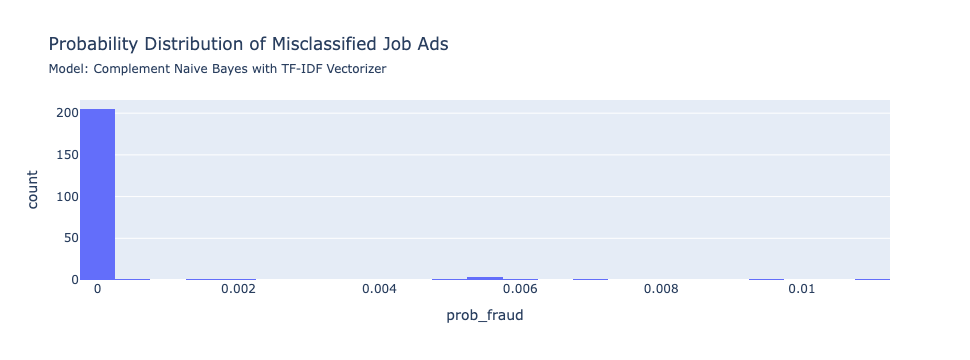

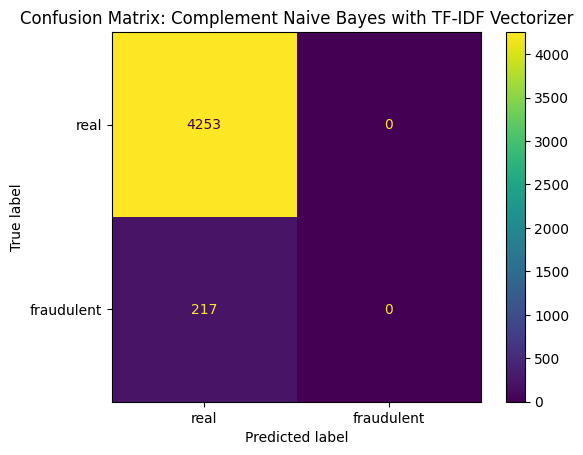

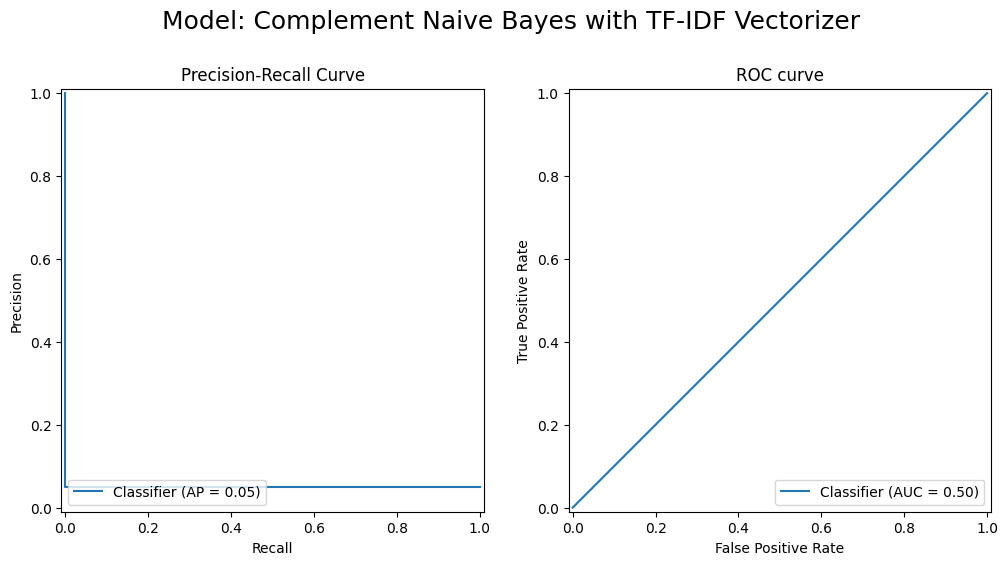

In [237]:
scores_comp_bayes_tfidf, res_comp_bayes_tfidf = evaluate_model(
    model_comp_bayes_tfidf, X_test, y_test, 
    fig_subtitle= 'Complement Naive Bayes with TF-IDF Vectorizer', 
    short_name='comp_bayes_tfidf', 
    save_figs=True,
    return_misclassified = False,
    return_all_results = True
)

In [238]:
save_model(model_comp_bayes_tfidf)

TypeError: save_model() missing 1 required positional argument: 'filename'

In [ ]:
res_comp_bayes_tfidf.to_csv('../data/results/res_comp_bayes_tfidf.csv')

In [ ]:
scores_comp_bayes_tfidf

#### TF-IDF Vectorizer and PCA

In [ ]:
model_comp_bayes_tfidf_pca = Pipeline([
    ('ct', ColumnTransformer([
        ('tfidf', TfidfVectorizer(ngram_range=(1,2)), 'job_ad'),
        ('ohe', OneHotEncoder(drop='first'), ['employment_type', 'required_experience']),
    ], remainder= 'passthrough', force_int_remainder_cols=False)),
    ('pca', PCA()),
    ('bayes', ComplementNB())
])

In [ ]:
model_comp_bayes_tfidf_pca.fit(X_train, y_train)

In [ ]:
scores_comp_bayes_tfidf_pca, res_comp_bayes_tfidf_pca = evaluate_model(
    model_comp_bayes_tfidf_pca, X_test, y_test, 
    fig_subtitle= 'Complement Bayes with TF-IDF Vectorizer and PCA', 
    short_name='comp_bayes_tfidf_pca', 
    save_figs=True,
    return_misclassified = False,
    return_all_results = True
)

In [ ]:
save_model(model_comp_bayes_tfidf_pca)

In [59]:
res_comp_bayes_tfidf_pca.to_csv('../data/results/res_comp_bayes_tfidf_pca.csv')

In [ ]:
scores_comp_bayes_tfidf_pca

## Support Vector Machine (SVM) Models

Support Vector Machine (SVM) models use a function, known as a kernel, to project the data into a higher dimensional space, draws a hyperplane to separate the classes and then returns to the original parameter space.  Sadly, this separating hyperplane is _not_ guaranteed to exist.  If it does not exist, then support vector classifiers (SVC) use a _soft margin_ to find the hyperplane that works best for most of the data points.  "Soft" means that there will be a few data points on the wrong side of the hyperplane, but the model works to keep these data points as close to the hyperplane as possible.

#### SVC with TF-IDF Vectorizer

In [239]:
model_svc_tfidf = Pipeline([
    ('ct', ColumnTransformer([
        ('tfidf', TfidfVectorizer(ngram_range=(1,2)), 'job_ad'),
        ('ohe', OneHotEncoder(drop='first'), ['employment_type', 'required_experience']),
    ], remainder= 'passthrough', force_int_remainder_cols=False)),
    ('svc', LinearSVC())
])

By default, the linear SVC model employs $\ell_2$ penalty (Ridge regularization) and uses a squared hinge loss function.

In [240]:
model_svc_tfidf.fit(X_train, y_train)

Pipeline(steps=[('ct',
                 ColumnTransformer(force_int_remainder_cols=False,
                                   remainder='passthrough',
                                   transformers=[('tfidf',
                                                  TfidfVectorizer(ngram_range=(1,
                                                                               2)),
                                                  'job_ad'),
                                                 ('ohe',
                                                  OneHotEncoder(drop='first'),
                                                  ['employment_type',
                                                   'required_experience'])])),
                ('svc', LinearSVC())])


Classification Report: 

              precision    recall  f1-score   support

        real       0.99      1.00      0.99      4253
  fraudulent       0.98      0.71      0.83       217

    accuracy                           0.99      4470
   macro avg       0.98      0.86      0.91      4470
weighted avg       0.99      0.99      0.98      4470



/var/folders/ty/qfl4p5vd2d3cxdrb54zzgq9w0000gn/T/ipykernel_39070/547252702.py:38: UserWarning:

FigureCanvasAgg is non-interactive, and thus cannot be shown



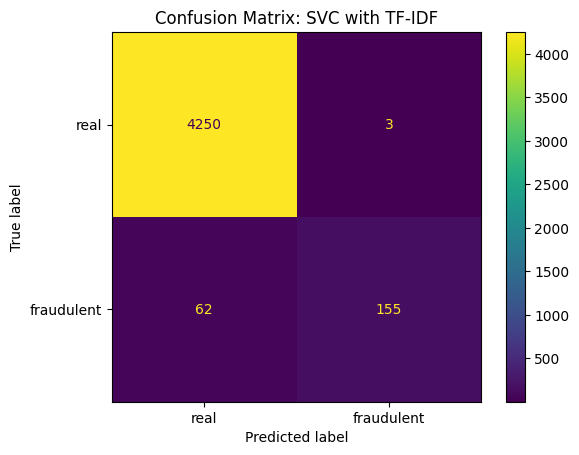

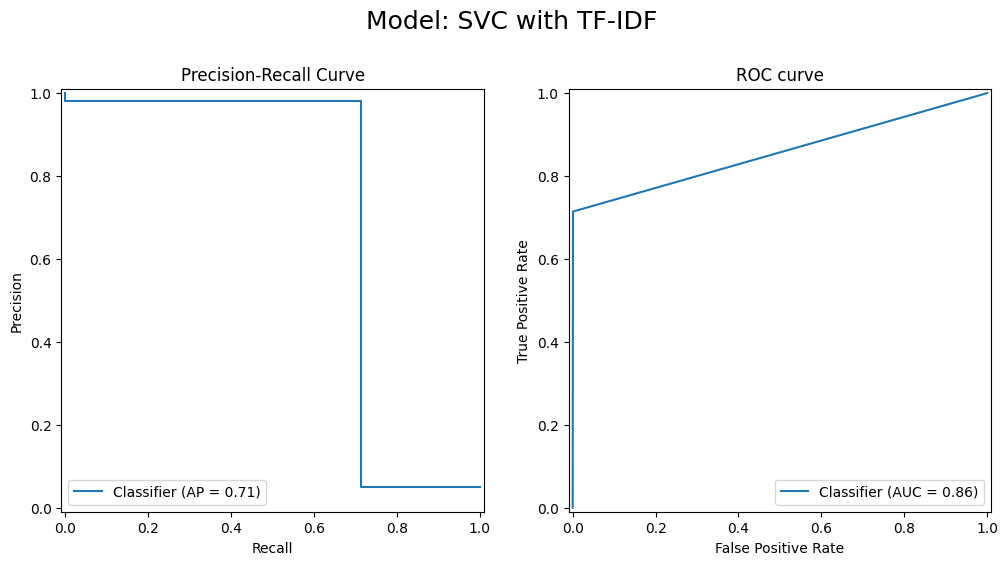

In [249]:
scores_svc_tfidf, res_svc_tfidf = evaluate_model_noprob(
    model_svc_tfidf, X_test, y_test, 
    fig_subtitle= 'SVC with TF-IDF', 
    short_name='svc_tfidf', 
    save_figs=True,
    return_all_results = True
)

In [250]:
save_model(model_svc_tfidf, 'model_svc_tfidf')

In [251]:
res_svc_tfidf.to_csv('../data/results/res_svc_tfidf.csv')

In [252]:
scores_svc_tfidf

{'model': 'svc_tfidf',
 'accuracy': 0.9854586129753915,
 'precision': 0.9810126582278481,
 'recall': 0.7142857142857143,
 'f1-score': 0.8266666666666667,
 'roc-auc-score': 0.8567901649255988}

In [13]:
model_tfidf_svc.feature_names_in_

array(['telecommuting', 'has_company_logo', 'has_questions',
       'employment_type', 'required_experience', 'job_ad'], dtype=object)

In [15]:
Cs = np.logspace(-8,4,11)

In [16]:
Cs

array([1.00000000e-08, 1.58489319e-07, 2.51188643e-06, 3.98107171e-05,
       6.30957344e-04, 1.00000000e-02, 1.58489319e-01, 2.51188643e+00,
       3.98107171e+01, 6.30957344e+02, 1.00000000e+04])

In [17]:
model_tfidf_svc.get_params()

{'memory': None,
 'steps': [('ct',
   ColumnTransformer(force_int_remainder_cols=False, remainder='passthrough',
                     transformers=[('tfidf', TfidfVectorizer(ngram_range=(1, 2)),
                                    'job_ad'),
                                   ('ohe', OneHotEncoder(drop='first'),
                                    ['employment_type', 'required_experience'])])),
  ('svc', LinearSVC())],
 'transform_input': None,
 'verbose': False,
 'ct': ColumnTransformer(force_int_remainder_cols=False, remainder='passthrough',
                   transformers=[('tfidf', TfidfVectorizer(ngram_range=(1, 2)),
                                  'job_ad'),
                                 ('ohe', OneHotEncoder(drop='first'),
                                  ['employment_type', 'required_experience'])]),
 'svc': LinearSVC(),
 'ct__force_int_remainder_cols': False,
 'ct__n_jobs': None,
 'ct__remainder': 'passthrough',
 'ct__sparse_threshold': 0.3,
 'ct__transformer_weights': N

In [18]:
params_svc = {
    'svc__C': Cs
}

In [20]:
grid_svc = GridSearchCV(model_tfidf_svc, param_grid= params_svc)

In [22]:
grid_svc.fit(X_train, y_train)

/Users/erindepree/venvs/dsb_602/lib/python3.11/site-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/erindepree/venvs/dsb_602/lib/python3.11/site-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/erindepree/venvs/dsb_602/lib/python3.11/site-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/erindepree/venvs/dsb_602/lib/python3.11/site-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/erindepree/venvs/dsb_602/lib/python3.11/site-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/erindepree/venvs/dsb_602/lib/python3.11/sit

GridSearchCV(estimator=Pipeline(steps=[('ct',
                                        ColumnTransformer(force_int_remainder_cols=False,
                                                          remainder='passthrough',
                                                          transformers=[('tfidf',
                                                                         TfidfVectorizer(ngram_range=(1,
                                                                                                      2)),
                                                                         'job_ad'),
                                                                        ('ohe',
                                                                         OneHotEncoder(drop='first'),
                                                                         ['employment_type',
                                                                          'required_experience'])])),
                                       ('svc', LinearSVC())]),
             param_grid={'svc__C': array([1.00000000e-08, 1.58489319e-07, 2.51188643e-06, 3.98107171e-05,
       6.30957344e-04, 1.00000000e-02, 1.58489319e-01, 2.51188643e+00,
       3.98107171e+01, 6.30957344e+02, 1.00000000e+04])})

In [23]:
grid_svc.best_score_
grid_svc.best_params_

{'svc__C': 2.5118864315095824}

In [28]:
grid_svc.best_score_

0.9866517524235645


Classification Report: 

              precision    recall  f1-score   support

        real       0.99      1.00      0.99      4253
  fraudulent       0.99      0.73      0.84       217

    accuracy                           0.99      4470
   macro avg       0.99      0.87      0.92      4470
weighted avg       0.99      0.99      0.99      4470



0.9865771812080537

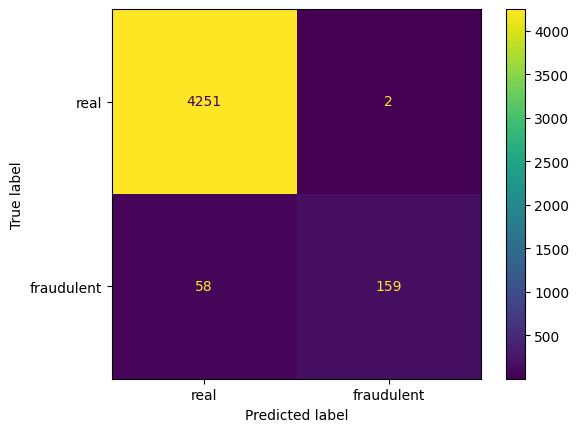

In [31]:
evaluate_model_noprob(grid_svc, X_test, y_test,
              fig_subtitle= "Model: Linear SVC (ridge reg) with TF-IDF Vectorizer, with C = 2.5",
              short_name = 'svc_tfidf_best_param', save_figs=True )

In [37]:
with open('models/svc_opt.pkl', 'wb') as f:
    pickle.dump(grid_svc, f)

In [ ]:
model_tfidf_svc = Pipeline([
    ('ct', ColumnTransformer([
        ('tfidf', TfidfVectorizer(ngram_range=(1,2)), 'job_ad'),
        ('ohe', OneHotEncoder(drop='first'), ['employment_type', 'required_experience']),
    ], remainder= 'passthrough', force_int_remainder_cols=False)),
    ('svc', LinearSVC())
])

In [ ]:
model_tfidf_svc.fit(X_train, y_train)

In [ ]:
evaluate_model(model_tfidf_svc, X_test, y_test, 
               fig_subtitle= 'Model: Support Vector Classifier (Ridge regularization) with TF-IDF Vectorizer', 
               short_name='svc_tfidf_ridge', save_figs=True)

## Stochastic Gradient Descent (SGD) Classifiers

comments

In [253]:
model_sgd_tfidf = Pipeline([
    ('ct', ColumnTransformer([
        ('tfidf', TfidfVectorizer(ngram_range=(1,2)), 'job_ad'),
        ('ohe', OneHotEncoder(drop='first'), ['employment_type', 'required_experience']),
    ], remainder= 'passthrough', force_int_remainder_cols=False)),
    ('sgd', SGDClassifier())
])

In [254]:
model_sgd_tfidf.fit(X_train, y_train)

Pipeline(steps=[('ct',
                 ColumnTransformer(force_int_remainder_cols=False,
                                   remainder='passthrough',
                                   transformers=[('tfidf',
                                                  TfidfVectorizer(ngram_range=(1,
                                                                               2)),
                                                  'job_ad'),
                                                 ('ohe',
                                                  OneHotEncoder(drop='first'),
                                                  ['employment_type',
                                                   'required_experience'])])),
                ('sgd', SGDClassifier())])


Classification Report: 

              precision    recall  f1-score   support

        real       0.98      1.00      0.99      4253
  fraudulent       1.00      0.64      0.78       217

    accuracy                           0.98      4470
   macro avg       0.99      0.82      0.89      4470
weighted avg       0.98      0.98      0.98      4470



/var/folders/ty/qfl4p5vd2d3cxdrb54zzgq9w0000gn/T/ipykernel_39070/547252702.py:38: UserWarning:

FigureCanvasAgg is non-interactive, and thus cannot be shown



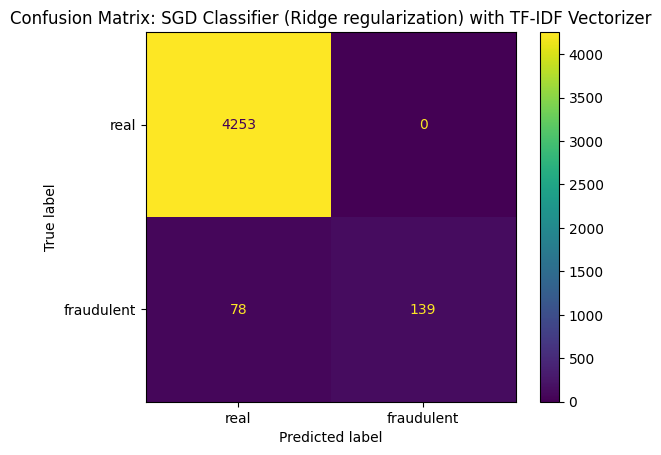

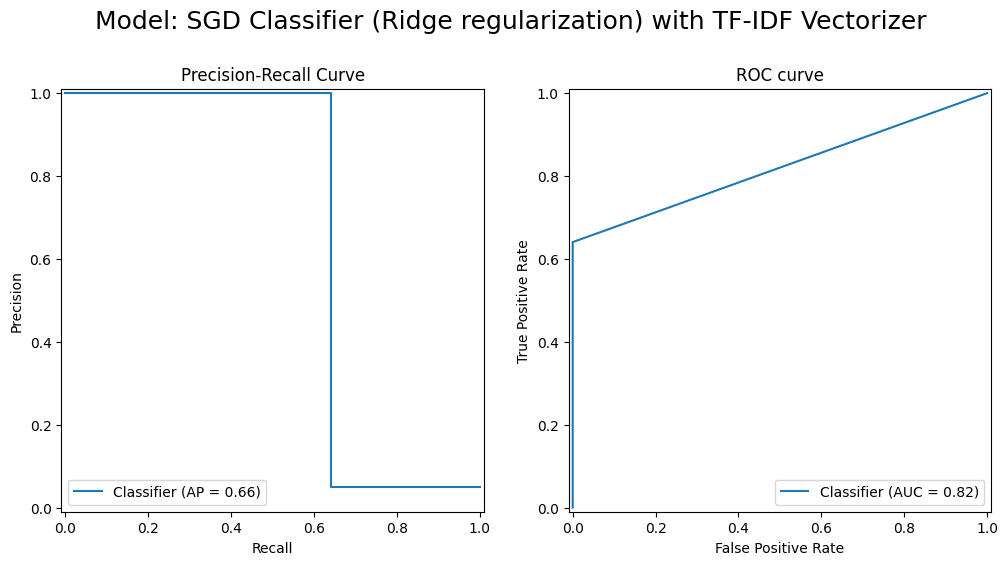

In [255]:
scores_sgd_tfidf, res_sgd_tfidf = evaluate_model_noprob(
    model_sgd_tfidf, X_test, y_test, 
    fig_subtitle= 'SGD Classifier (Ridge regularization) with TF-IDF Vectorizer', 
    short_name='sgd_tfidf_ridge', 
    save_figs=True,
    return_all_results = True
)

In [257]:
save_model(model_sgd_tfidf, 'model_sgd_tfidf')

In [258]:
res_sgd_tfidf.to_csv('../data/results/res_sgd_tfidf.csv')

In [259]:
scores_sgd_tfidf

{'model': 'sgd_tfidf_ridge',
 'accuracy': 0.9825503355704698,
 'precision': 1.0,
 'recall': 0.6405529953917051,
 'f1-score': 0.7808988764044944,
 'roc-auc-score': 0.8202764976958525}

## KNeighbors Classifier

#### Model

In [260]:
model_kn_tfidf = Pipeline([
    ('ct', ColumnTransformer([
        ('tfidf', TfidfVectorizer(ngram_range=(1,2)), 'job_ad'),
        ('ohe', OneHotEncoder(drop='first'), ['employment_type', 'required_experience']),
    ], remainder= 'passthrough', force_int_remainder_cols=False)),
    ('kn', KNeighborsClassifier())
])

In [261]:
model_kn_tfidf.fit(X_train, y_train)

Pipeline(steps=[('ct',
                 ColumnTransformer(force_int_remainder_cols=False,
                                   remainder='passthrough',
                                   transformers=[('tfidf',
                                                  TfidfVectorizer(ngram_range=(1,
                                                                               2)),
                                                  'job_ad'),
                                                 ('ohe',
                                                  OneHotEncoder(drop='first'),
                                                  ['employment_type',
                                                   'required_experience'])])),
                ('kn', KNeighborsClassifier())])


Classification Report: 

              precision    recall  f1-score   support

        real       0.98      0.99      0.99      4253
  fraudulent       0.78      0.65      0.71       217

    accuracy                           0.97      4470
   macro avg       0.88      0.82      0.85      4470
weighted avg       0.97      0.97      0.97      4470



/var/folders/ty/qfl4p5vd2d3cxdrb54zzgq9w0000gn/T/ipykernel_39070/3203830892.py:37: UserWarning:

FigureCanvasAgg is non-interactive, and thus cannot be shown



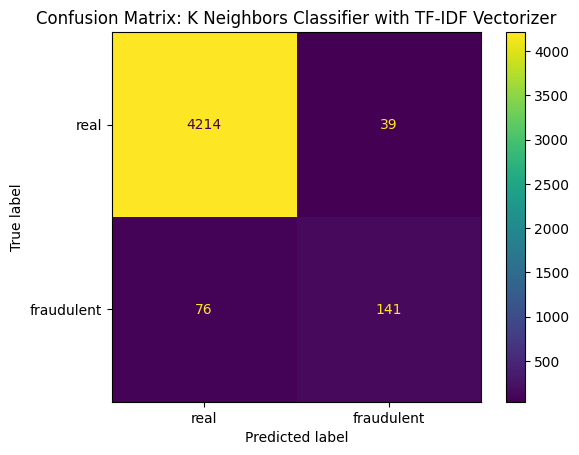

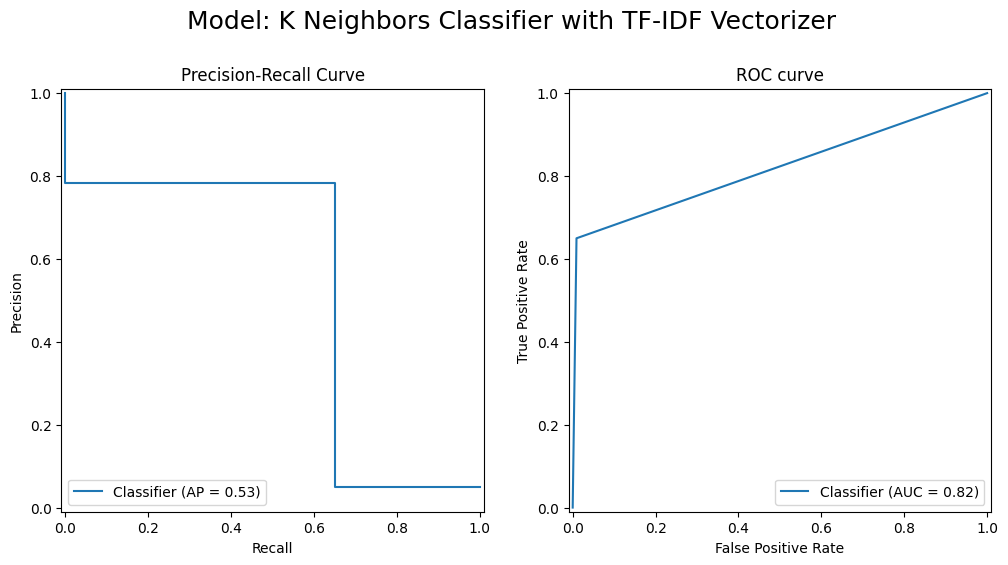

In [262]:
scores_kn_tfidf, res_kn_tfidf = evaluate_model(
    model_kn_tfidf, X_test, y_test, 
    fig_subtitle= 'K Neighbors Classifier with TF-IDF Vectorizer', 
    short_name='kn_tfidf', 
    save_figs=True,
    return_misclassified = False,
    return_all_results = True
)

In [263]:
save_model(model_kn_tfidf, 'model_kn_tfidf')

In [264]:
res_kn_tfidf.to_csv('../data/results/res_kn_tfidf.csv')

In [265]:
scores_kn_tfidf

{'model': 'kn_tfidf',
 'accuracy': 0.9742729306487695,
 'precision': 0.7833333333333333,
 'recall': 0.6497695852534562,
 'f1-score': 0.7103274559193955,
 'roc-auc-score': 0.8202997938023688}

## Summary

In [267]:
all_scores = [
    scores_log_cv, 
    scores_log_tfidf,
    scores_log_cv_pca,
    scores_log_cv_pca_200,
    scores_log_cv_pca_300,
    scores_log_cv_pca_500,
    scores_log_cv_pca_stop,
    scores_log_cv_stop,
    scores_log_tfidf_pca,
    scores_log_tfidf_ridge_pca,
    scores_log_tfidf_lasso_pca,
    scores_random_tfidf_pca,
    scores_cv_bayes,
    scores_comp_bayes_cv,
    scores_comp_bayes_tfidf,
    scores_svc_tfidf,
    scores_sgd_tfidf,
    scores_kn_tfidf
]

In [269]:
all_scores_df = pd.DataFrame(all_scores)

In [270]:
all_scores_df.to_csv('./models/scores.csv')

In [46]:
all_scores_df = pd.read_csv('./models/scores.csv').drop(columns=['Unnamed: 0'])

In [66]:
all_scores_df = pd.concat([scores_base, all_scores_df], ignore_index=True, axis=0)

In [67]:
all_scores_df

,model,accuracy,precision,recall,f1-score,roc-auc-score
0,base,0.951678,0.000000,0.000000,0.000000,0.500000
1,log_cv,0.984340,0.897297,0.764977,0.825871,0.880255
2,log_tfidf,0.987248,0.925532,0.801843,0.859259,0.899276
3,log_cv_pca,0.962864,0.831169,0.294931,0.435374,0.645937
4,log_cv_pca_200,0.969128,0.855856,0.437788,0.579268,0.717013
5,log_cv_pca_300,0.969575,0.775510,0.525346,0.626374,0.758793
6,log_cv_pca_500,0.971812,0.721951,0.682028,0.701422,0.834313
7,log_cv_pca_stop,0.967562,0.846154,0.405530,0.548287,0.700884
8,log_cv_stop,0.985682,0.922652,0.769585,0.839196,0.883147
9,log_tfidf_pca,0.967338,0.838095,0.405530,0.546584,0.700766


In [70]:
all_scores_df.style.apply(highlight_max, props='color:white;background-color:darkblue', 
                          axis=0, subset=['accuracy','precision','recall', 'f1-score','roc-auc-score'])

,model,accuracy,precision,recall,f1-score,roc-auc-score
0,base,0.951678,0.000000,0.000000,0.000000,0.500000
1,log_cv,0.984340,0.897297,0.764977,0.825871,0.880255
2,log_tfidf,0.987248,0.925532,0.801843,0.859259,0.899276
3,log_cv_pca,0.962864,0.831169,0.294931,0.435374,0.645937
4,log_cv_pca_200,0.969128,0.855856,0.437788,0.579268,0.717013
5,log_cv_pca_300,0.969575,0.775510,0.525346,0.626374,0.758793
6,log_cv_pca_500,0.971812,0.721951,0.682028,0.701422,0.834313
7,log_cv_pca_stop,0.967562,0.846154,0.405530,0.548287,0.700884
8,log_cv_stop,0.985682,0.922652,0.769585,0.839196,0.883147
9,log_tfidf_pca,0.967338,0.838095,0.405530,0.546584,0.700766


In [12]:
np.max(all_scores_df['accuracy'].values)

0.987248322147651

In [ ]:
np.where()